In [184]:
# Imports
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import functions

import datetime


#Settings
pd.set_option("display.max_rows", 70)
pd.set_option("display.max_columns", 101)

# Task Description

Case description:
Welcome to East Carmen Airlines! As a strategic data scientist, you are confronted with many use cases to digitalize the airline business. Most important for airlines are accurate predictions of flight arrivals during a day of operations. When it comes to passenger handling, such predictions would admit a proactive steering, in order that the passengers reach the connection flights and therefore save a lot of money.

Your model should be applicable to each aircraft in East Carmen’s fleet. Let us take as an example the aircraft with registration name EC-LPD. At scheduled departure of the earliest morning flight from East Carmen’s hub Madrid the model should predict all flights of EC-LPD on the given day.

Many business stakeholders do not trust in the robustness of such a model. They claim that for a given aircraft, one could predict the first flight of the day with a decent error, but the errors of second and third flights will be huge. It is now your task to convince the business stakeholders that with a well-prepared data set and meaningful features you can deliver robust flight predictions.

Project Aim:
From different departments business analysts have collected a lot of information on possible features for flight predictions. Now it is your task to use these data to deliver a prototype forecasting model for all flights of a given aircraft at scheduled departure of the first flight of the day. 

For instance, for an aircraft with registration name EC-LPD, first flight of the day (FFOD) scheduled at 5:30 am from MAD to VIE and with the connection chain MAD-VIE-MAD-CDG-MAD-LHR-MAD your model should predict the successive landing times in VIE, MAD, CDG, MAD, LHR, MAD. The colleagues from daily operations are especially interested in how the confidence level of such a model evolves during a day of operations.

# General Information

3.1 File Names
- zip-folder: use_case_3.zip
- flight_information.csv : information on flights in a given time period, where each data point is a so-called 
leg, i.e. a flight from departure airport to destination airport with all relevant flight and crew information
- ground_information.csv : information on the ground processes after landing at our hub “East Carmen”,
where each data point describes the processes between two flights (inbound = landing, outbound = takeoff).


3.2 Column Description – Flight Information
- leg_no: unique identifier of a flight on a given day, at a certain time, with a given flight number
- fn_carrier: airline name
- fn_number: flight number; has to be unique on a given day
- dep_ap_sched: scheduled departure airport
- arr_ap_sched: scheduled arrival airport
- dep_sched_date: scheduled departure date
- dep_sched_time: scheduled departure time
- arr_sched_date: scheduled arrival date
- arr_sched_time: scheduled arrival time
- m_offblockdt: timestamp of departure
- m_onblockdt: timestamp of arrival
- ac_registration: aircraft registration number, i.e. the “license plate” of the aircraft
- change_reason_code: reason for delay (assigned after the flight)
- dep_delay: departure delay
- Ac Type Code: aircraft type (example: 320 = Airbus A320)
- trans_time: true minimal transition time for crew members after flight, i.e. transition time of the crew
member with the least time
- sched_trans_time: scheduled minimal transition time for crew members after flight, i.e. scheduled transition
time of the crew member with the least time
4
- Crew Group: assignment of what happens to the whole crew after a flight
o Start : First flight of day
o A : all crew members stay on the aircraft for the next flight
o B, B2: all crew members switch aircraft for the next flight
o C: at least one crew member switches aircraft for the next flight
- TLC_trans: names of crew members on flight with some additional information attached to each name (but business does not know exactly which additional information is visible there)
- crew_type_change: rank (cp = pilot, ca = cabin member) of crew members, who changed aircraft
- Sched Groundtime: scheduled ground time of the aircraft between flights | has mistakes; mostly (dep_sched_time of next line) - (arr_sched_time of current line); groundtime AFTER landing
- Act Groundtime: actual ground time of the aircraft between flights | has mistakes; mostly (m_offblocktime of next line) - (m_onblocktime of current line); groundtime AFTER landing


3.3 Column Description – Ground Information
- Each datapoint consists of an inbound (=arriving) flight and an outbound (=departing) flight from our hub “East Carmen)
- Catering, cleaning and pax (=passenger) boarding durations given for our hub “East Carmen” between the inbound and outbound flights
- day_of_origin: day of flight (also given in Flight Information)
- ac_type: aircraft type (also given in Flight Information)
- fn_number: flight number (also given in Flight Information)
- ac_registration: aircraft registration (also given in Flight Information)
- mingt: minimal scheduled ground time for the given aircraft
- dep_leg_inbound: departure airport name of inbound (=arriving) flight
- arr_leg_inbound: arrival airport name of inbound (=arriving) flight
- arr_leg_outbound: departure airport name of outbound (=departing) flight
- sched_inbound_dep: scheduled departure time of inbound (=arriving) flight
- sched_inbound_arr: scheduled arrival time of inbound (=arriving) flight
- sched_outbound_dep: scheduled departure time of outbound (=departing) flight
- sched_outbound_arr: scheduled arrival time of outbound (=departing) flight
- sched_turnaround: scheduled ground time for aircraft
- leg_inbound: leg number of inbound flight
- leg_outbound: leg number of outbound flight
- catering_duration: catering duration (i.e. filling up meal boxes) between flights in minutes
- cleaning_duration: cleaning duration between flights in minutes
- pax_boarding_duration: boarding duration between flights in minutes


3.4 Additional Info from Business Side:
- BI (=business intelligence) colleagues have collected a lot of flight information from many different de-partments: flight-, crew- and ground operations. Each department uses a different data warehouse. BI colleagues claim that some of the columns might be redundant and some information could be wrong, due to bad and not consistent data in the different data warehouses of the business departments. It is central for this prototype study to clean and transform the data and make consistency checks, before applying a machine learning algorithm.

# Initial Dataset Structure

In [185]:
# some general functions

def na_count(dataframe):
    '''Takes a Pandas dataframe as input and returns NA-Values per attribute.'''
    for attribute in dataframe.columns:
        nan_abs = str(dataframe[attribute].isna().sum()) 
        nan_percent = str(round(dataframe[attribute].isna().sum() / dataframe.shape[0] *100, 2))

        print(str(attribute) + " NAs: " + nan_abs + "(" + nan_percent + "%)" )



In [186]:
# Read files 

flt_info = pd.read_csv('../data/raw/flight_information.csv', index_col = 0)
ground_info = pd.read_csv('../data/raw/ground_information.csv', index_col = 0)

# Variable type conversions

data_type_dict_flt_info = {
    'm_offblockdt' : 'datetime64',
    'm_onblockdt' : 'datetime64',
    'arr_sched_time' : 'str',
    'dep_sched_time' : 'str',
    'dep_sched_date' : 'datetime64',
    'arr_sched_date' : 'datetime64',
}

data_type_dict_ground_info = {
    'day_of_origin' : 'datetime64',
    'sched_inbound_dep' : 'datetime64',
    'sched_inbound_arr' : 'datetime64',
    'sched_outbound_dep' : 'datetime64',
    'sched_outbound_arr' : 'datetime64',
}

flt_info = flt_info.astype(data_type_dict_flt_info)
ground_info = ground_info.astype(data_type_dict_ground_info)

# Create correct datetimes for arr_sched_time and dep_sched_time
flt_info['dep_sched_time'] = pd.to_datetime(flt_info.dep_sched_date.astype(str) + ' ' + flt_info.dep_sched_time.astype(str))
flt_info['arr_sched_time'] = pd.to_datetime(flt_info.arr_sched_date.astype(str) + ' ' + flt_info.arr_sched_time.astype(str))


# Joining Datasets
full_df = pd.merge(flt_info, ground_info, left_on = ['leg_no'], right_on = ['leg_inbound'], how = 'left')

# We save the full unedited dataset
full_df_unedited = full_df
full_df_unedited.to_csv('../data/interim/full_df_unedited.csv')
full_df_unedited.to_pickle('../data/interim/full_df_unedited.pkl')

full_df.head()

,leg_no,fn_carrier,fn_number_x,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,ac_type,fn_number_y,ac_registration_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration
0,272005011,East Carmen Airlines,EC3098,North Gregory,East Carmen,2019-06-01,2019-06-01 00:40:00,2019-06-01,2019-06-01 04:30:00,2019-06-01 00:43:00,2019-06-01 04:12:00,ECLBSX,other problem,3.0,320,0,0,Start,"['Jason Brown_nan_nan_nan_cp', 'Jacob Stein_na...",[],235.0,268.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,272009188,East Carmen Airlines,EC3146,Port Bobby,East Carmen,2019-06-01,2019-06-01 02:05:00,2019-06-01,2019-06-01 04:00:00,2019-06-01 01:58:00,2019-06-01 03:40:00,ECLWHX,no reason,-7.0,E95,0,0,Start,"['Scott Baker_nan_nan_nan_cp', 'Ruth Hoffman_n...",[],130.0,189.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,271984537,East Carmen Airlines,EC2840,Port Ryan,East Carmen,2019-06-01,2019-06-01 02:20:00,2019-06-01,2019-06-01 03:50:00,2019-06-01 02:24:00,2019-06-01 03:57:00,ECLGLX,other problem,4.0,DH4,0,0,Start,"['Cory Cooper_nan_nan_nan_ca', 'Morgan Foster_...",[],185.0,196.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,272025831,East Carmen Airlines,EC3306,Coleland,East Carmen,2019-06-01,2019-06-01 02:25:00,2019-06-01,2019-06-01 04:00:00,2019-06-01 02:28:00,2019-06-01 03:49:00,ECLBMX,other problem,3.0,320,0,0,Start,"['Anne Davis_nan_nan_nan_ca', 'Miss Amanda Har...",[],145.0,175.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,272006092,East Carmen Airlines,EC3114,East Melissaberg,East Carmen,2019-06-01,2019-06-01 02:30:00,2019-06-01,2019-06-01 04:15:00,2019-06-01 03:02:00,2019-06-01 04:43:00,ECLGNX,other problem,32.0,DH4,0,0,Start,"['Renee Fisher_nan_nan_nan_ca', 'Rebecca Castr...",[],35.0,21.0,2019-06-01,DH4,EC3114,ECLGNX,35.0,East Melissaberg,East Carmen,Keithberg,2019-06-01 02:30:00,2019-06-01 04:15:00,2019-06-01 04:50:00,2019-06-01 05:40:00,35.0,272006092.0,272205857.0,26.0,NaN,26.0


# Data Quality Analysis

In [187]:
# Count of rows and columns of our data set
full_df.shape

(12101, 40)

In [188]:
flt_info.shape

(12017, 22)

In [189]:
ground_info.shape

(4173, 18)

## Merge Quality Assessment

Check whether the variables that are not included in the join have the same values in both datasets

In [190]:
full_df.columns

Index(['leg_no', 'fn_carrier', 'fn_number_x', 'dep_ap_sched', 'arr_ap_sched',
       'dep_sched_date', 'dep_sched_time', 'arr_sched_date', 'arr_sched_time',
       'm_offblockdt', 'm_onblockdt', 'ac_registration_x',
       'change_reason_code', 'dep_delay', 'Ac Type Code', 'trans_time',
       'sched_trans_time', 'Crew Group', 'TLC_trans', 'crew_type_change',
       'Sched Groundtime', 'Act Groundtime', 'day_of_origin', 'ac_type',
       'fn_number_y', 'ac_registration_y', 'mingt', 'dep_leg_inbound',
       'arr_leg_inbound', 'arr_leg_outbound', 'sched_inbound_dep',
       'sched_inbound_arr', 'sched_outbound_dep', 'sched_outbound_arr',
       'sched_turnaround', 'leg_inbound', 'leg_outbound', 'catering_duration',
       'cleaning_duration', 'pax_boarding_duration'],
      dtype='object')

In [191]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
full_df.describe(include = 'all')

,leg_no,fn_carrier,fn_number_x,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,ac_type,fn_number_y,ac_registration_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration
count,1.210100e+04,12101,12101,12101,12101,12101,12101,12101,12101,12101,12018,12101,12101,12101.000000,12101,12101.000000,12101.000000,12101,12101,12101,10088.000000,10026.000000,4229,4229,4229,4229,4229.000000,4229,4229,4224,4229,4229,4229,4229,4229.000000,4.229000e+03,4.229000e+03,4229.000000,3.000000,3817.000000
unique,NaN,1,614,113,112,30,4901,31,4993,9731,9819,70,4,NaN,3,NaN,NaN,5,11927,56,NaN,NaN,30,7,257,69,NaN,102,4,103,2624,2282,2158,2554,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,East Carmen Airlines,EC11860,East Carmen,East Carmen,2019-06-13 00:00:00,2019-06-20 08:00:00,2019-06-13 00:00:00,2019-06-06 12:20:00,2019-06-20 10:44:00,2019-06-20 12:38:00,ECLWEX,other problem,NaN,320,NaN,NaN,A,"['Alejandro Rivera_10_73_45_ca', 'Morgan Melen...",[],NaN,NaN,2019-06-13 00:00:00,320,EC11860,ECLBNX,NaN,West Bryanstad,East Carmen,West Jason,2019-06-20 10:30:00,2019-06-15 17:15:00,2019-06-27 13:20:00,2019-06-03 12:20:00,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,12101,75,5448,5529,422,16,422,14,10,10,214,7528,NaN,6115,NaN,NaN,6095,5,10074,NaN,NaN,162,1535,56,85,NaN,158,4226,175,14,11,11,12,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,2019-06-01 00:00:00,2019-06-01 00:40:00,2019-06-01 00:00:00,2019-06-01 03:50:00,2019-06-01 00:43:00,2019-06-01 03:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-01 02:30:00,2019-06-01 04:15:00,2019-06-01 04:50:00,2019-06-01 05:40:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2019-06-30 00:00:00,2019-06-30 23:15:00,2019-07-01 00:00:00,2019-07-01 04:00:00,2019-06-30 23:19:00,2019-07-01 04:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-30 19:20:00,2019-06-30 20:10:00,2019-06-30 21:10:00,2019-06-30 23:05:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.720519e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.805884,NaN,27.815305,35.086770,NaN,NaN,NaN,61.513184,64.784560,NaN,NaN,NaN,NaN,39.117995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.066446,2.720601e+08,2.720432e+08,21.961693,21.505556,18.467645
std,9.604818e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.596928,NaN,31.861892,31.448448,NaN,NaN,NaN,58.419525,73.810088,NaN,NaN,NaN,NaN,3.250068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.975623,9.904749e+04,9.309438e+04,4.324847,10.667400,11.913937
min,2.719556e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-14.000000,NaN,-134.000000,0.000000,NaN,NaN,NaN,-245.000000,-383.000000,NaN,NaN,NaN,NaN,30.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-120.000000,2.719558e+08,2.719560e+08,15.000000,14.000000,0.000000
25%,2.719829e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,45.000000,33.000000,NaN,NaN,NaN,NaN,40.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.000000,2.719897e+08,2.719841e+08,18.000000,15.400000,13.000000


Notes

We see that we only have one distinct value for fn_carrier, which means we can drop the column. 

In [192]:
# fn_carrier
full_df = full_df.drop('fn_carrier', axis = 1)

In [193]:
# Registration
reg_diff = full_df['ac_registration_x'].compare(full_df['ac_registration_y']).dropna().shape
print(reg_diff[0], " rows are differing for Registration. ac_registration_y will be dropped.")
full_df = full_df.drop('ac_registration_y', axis = 1)

0  rows are differing for Registration. ac_registration_y will be dropped.


In [194]:
# Check whether departure airports differ in between data sets
dep_ap_sched_diff = full_df['dep_ap_sched'].compare(full_df['dep_leg_inbound']).dropna()
print(dep_ap_sched_diff.shape)

# none, looking good


(0, 2)


## Variable Quality Assessment

Check of cleanliness of single variables

Scheduled Groundtime and Actual Groundtime

Here, we check whether Sched Groundtime and Act Groundtime were calculated correctly. We see that this is not the case and recalculate the values using a custom function from functions.py

In [195]:
import warnings
warnings.simplefilter(action='ignore')

def recalc_groundtimes_no_replace(df):
    df['act_groundtime_new'] = np.where(
        (df['ac_registration_x'].shift(-1).eq(df['ac_registration_x']) == True) & (df['Act Groundtime'].isna() == False),
        np.around((df['m_offblockdt'].shift(-1) - df['m_onblockdt']).dt.total_seconds()/60, decimals =1),
        df['Act Groundtime']
    )
    df['sched_groundtime_new'] = np.where(
        (df['ac_registration_x'].shift(-1).eq(df['ac_registration_x']) == True) & (df['Sched Groundtime'].isna() == False),
        np.around((df['dep_sched_time'].shift(-1) - df['arr_sched_time']).dt.total_seconds()/60, decimals =1),
        df['Sched Groundtime']
    )

recalc_groundtimes_no_replace(full_df)

# rows which do not have correct actual ground time
temp = full_df[~(full_df['Act Groundtime'] == full_df['act_groundtime_new'])]
temp['act_gt_diff'] = temp['Act Groundtime'] - temp['act_groundtime_new']
temp['sched_gt_diff'] = temp['Sched Groundtime'] - temp['sched_groundtime_new']
print(str(temp[temp['act_groundtime_new'].isna() == False].shape[0]) + " rows have wrongly calculated ground times. We filter out NAs for Act Groundtime as the majority of them" +
    " are the last flights of the respective day.")

warnings.simplefilter(action='default')
temp[temp['act_groundtime_new'].isna() == False]

81 rows have wrongly calculated ground times. We filter out NAs for Act Groundtime as the majority of them are the last flights of the respective day.


,leg_no,fn_number_x,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,ac_type,fn_number_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,act_groundtime_new,sched_groundtime_new,act_gt_diff,sched_gt_diff
256,272104742,EC4498,Vaughnberg,Millerborough,2019-06-01,2019-06-01 13:20:00,2019-06-01,2019-06-01 13:55:00,2019-06-01 14:07:00,2019-06-01 14:37:00,ECLWEX,rotational problem,47.0,E95,58,50,A,"['Dominic Horton_226_58_50_ca', 'Jesus Martin_...",[],265.0,243.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,62.0,50.0,181.0,215.0
257,272104743,EC4498,Millerborough,East Carmen,2019-06-01,2019-06-01 14:45:00,2019-06-01,2019-06-01 17:15:00,2019-06-01 15:39:00,2019-06-01 18:13:00,ECLWEX,rotational problem,54.0,E95,58,50,A,"['Dominic Horton_226_58_50_ca', 'Jesus Martin_...",[],-150.0,-246.0,2019-06-01,E95,EC4498,40.0,Millerborough,East Carmen,East Holly,2019-06-01 14:45:00,2019-06-01 17:15:00,2019-06-01 18:20:00,2019-06-01 19:25:00,65.0,272104743.0,271994024.0,22.0,NaN,NaN,-154.0,-150.0,-92.0,0.0
258,272104743,EC4498,Millerborough,East Carmen,2019-06-01,2019-06-01 14:45:00,2019-06-01,2019-06-01 17:15:00,2019-06-01 15:39:00,2019-06-01 18:13:00,ECLWEX,rotational problem,54.0,E95,58,50,A,"['Dominic Horton_226_58_50_ca', 'Jesus Martin_...",[],-150.0,-246.0,2019-06-01,E95,EC4498,40.0,Millerborough,East Carmen,East Holly,2019-06-01 14:45:00,2019-06-01 17:15:00,2019-06-01 18:20:00,2019-06-01 19:25:00,65.0,272104743.0,271994024.0,27.0,NaN,NaN,-154.0,-150.0,-92.0,0.0
259,272104743,EC4498,Millerborough,East Carmen,2019-06-01,2019-06-01 14:45:00,2019-06-01,2019-06-01 17:15:00,2019-06-01 15:39:00,2019-06-01 18:13:00,ECLWEX,rotational problem,54.0,E95,58,50,A,"['Dominic Horton_226_58_50_ca', 'Jesus Martin_...",[],-150.0,-246.0,2019-06-01,E95,EC4498,40.0,Millerborough,East Carmen,East Holly,2019-06-01 14:45:00,2019-06-01 17:15:00,2019-06-01 18:20:00,2019-06-01 19:25:00,65.0,272104743.0,271994024.0,22.0,NaN,NaN,-154.0,-150.0,-92.0,0.0
296,272218010,EC11525,East Allisontown,Aaronbury,2019-06-01,2019-06-01 16:25:00,2019-06-01,2019-06-01 17:05:00,2019-06-01 16:28:00,2019-06-01 17:05:00,ECLBOX,other problem,3.0,320,52,45,A,"['Daniel Williams_223_52_45_ca', 'Morgan Moore...",[],50.0,53.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,84.0,50.0,-31.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11769,272088113,EC11860,New Stacyburgh,East Carmen,2019-06-30,2019-06-30 08:30:00,2019-06-30,2019-06-30 10:30:00,2019-06-30 08:50:00,2019-06-30 10:53:00,ECLBNX,other problem,20.0,320,60,45,A,"['Kevin Maddox_14_60_45_cp', 'Michelle Short_1...",[],-120.0,-242.0,2019-06-30,320,EC11860,40.0,New Stacyburgh,East Carmen,East Latashaview,2019-06-30 08:30:00,2019-06-30 10:30:00,2019-06-30 11:20:00,2019-06-30 14:45:00,50.0,272088113.0,272214012.0,20.0,NaN,15.0,-123.0,-120.0,-119.0,0.0
11770,272088113,EC11860,New Stacyburgh,East Carmen,2019-06-30,2019-06-30 08:30:00,2019-06-30,2019-06-30 10:30:00,2019-06-30 08:50:00,2019-06-30 10:53:00,ECLBNX,other problem,20.0,320,60,45,A,"['Kevin Maddox_14_60_45_cp', 'Michelle Short_1...",[],-120.0,-242.0,2019-06-30,320,EC11860,40.0,New Stacyburgh,East Carmen,East Latashaview,2019-06-30 08:30:00,2019-06-30 10:30:00,2019-06-30 11:20:00,2019-06-30 14:45:00,50.0,272088113.0,272214012.0,24.0,NaN,15.0,-123.0,-120.0,-119.0,0.0
11826,272088113,EC11860,New Stacyburgh,East Carmen,2019-06-30,2019-06-30 08:30:00,2019-06-30,2019-06-30 10:30:00,2019-06-30 08:50:00,2019-06-30 10:5

In [196]:
# Recalculation of ground times
functions.recalc_groundtimes(full_df)

AC Type

We see that ac_type from our ground dataset is richer in information variety, but more sparse in actual values. By using the registration and ac_type, we can impute the ac subtype for all rows

In [197]:
pd.crosstab(index = full_df['Ac Type Code'],columns=full_df['ac_type'])

ac_type,319,320,321,322,DH4,DHX,E95
Ac Type Code,,,,,,,
320,431,1535,165,159,0,0,0
DH4,0,0,0,0,587,225,0
E95,0,0,0,0,0,0,1127


In [198]:
pd.crosstab(index = full_df['ac_registration_x'],columns=full_df['ac_type'])

ac_type,319,320,321,322,DH4,DHX,E95
ac_registration_x,,,,,,,
ECLBAX,0,0,54,0,0,0,0
ECLBBX,0,0,55,0,0,0,0
ECLBCX,0,0,56,0,0,0,0
ECLBDX,0,0,0,51,0,0,0
ECLBEX,0,0,0,58,0,0,0
ECLBFX,0,0,0,50,0,0,0
ECLBIX,0,64,0,0,0,0,0
ECLBJX,0,53,0,0,0,0,0
ECLBKX,0,60,0,0,0,0,0


In [199]:
# get actual AC subtypes for Ac Type Code

ac_subtypes = full_df[['ac_type','ac_registration_x']].drop_duplicates().dropna()

full_df = pd.merge(left = full_df, right = ac_subtypes, how = 'left', on = 'ac_registration_x')
full_df['Ac Type Code'] = full_df['ac_type_y']
full_df.drop(['ac_type_x', 'ac_type_y'], axis = 1, inplace = True)
full_df.tail()

,leg_no,fn_number_x,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,fn_number_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,act_groundtime_new,sched_groundtime_new
12096,272033556,EC3399,East Carmen,Port Courtneytown,2019-06-30,2019-06-30 20:45:00,2019-06-30,2019-06-30 21:25:00,2019-06-30 20:59:00,2019-06-30 21:46:00,ECLGJX,other problem,14.0,DH4,27,35,A,"['Derek Sweeney_372_27_35_cp', 'John Hardin_37...",[],NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12097,272035064,EC3431,East Carmen,East Allisontown,2019-06-30,2019-06-30 20:45:00,2019-06-30,2019-06-30 21:20:00,2019-06-30 21:02:00,2019-06-30 21:46:00,ECLWJX,technical problem,17.0,E95,38,80,A,"['Linda Davidson_355_38_80_cp', 'Lisa Wilson_3...",[],NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12098,272003336,EC3077,East Carmen,Lake David,2019-06-30,2019-06-30 21:10:00,2019-06-30,2019-06-30 23:05:00,2019-06-30 21:27:00,2019-06-30 23:37:00,ECLGHX,other problem,17.0,DH4,0,0,Start,"['Andre Leblanc_nan_nan_nan_cp', 'Ronald Shaff...",[],NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12099,272025131,EC3299,East Carmen,Coleland,2019-06-30,2019-06-30 21:15:00,2019-06-30,2019-06-30 22:50:00,2019-06-30 21:35:00,2019-06-30 23:00:00,ECLBFX,other problem,20.0,322,0,0,Start,"['Paul Murray_nan_nan_nan_ca', 'James Lee_nan_...",[],NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12100,272028424,EC3328,South Haileyberg,East Carmen,2019-06-30,2019-06-30 23:15:00,2019-07-01,2019-07-01 04:00:00,2019-06-30 23:19:00,2019-07-01 04:01:00,ECLBOX,other problem,4.0,320,0,0,Start,"['Alicia Hansen_nan_nan_nan_ca', 'Charles Mart...",[],NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


mingt

We see that mingt is quite dependent on Ac Type code, so we might impute the values to all rows. Although it does not have predictive power in itself, we can use it for data cleaning.

In [200]:
# have a look at mingt per Aircraft Type
pd.crosstab(index = full_df['mingt'],columns=full_df['Ac Type Code'])


Ac Type Code,319,320,321,322,DH4,DHX,E95
mingt,,,,,,,
30.0,0,0,0,0,193,67,0
35.0,0,0,0,0,394,158,0
40.0,431,1533,0,0,0,0,1127
45.0,0,2,165,159,0,0,0


In [201]:
# no dependency on the registration
# This also means that mingt has no predictive power in itself as it does not posess more information than Ac Type Code. But maybe we can use it for data cleaning

# have a look at mingt per registration
pd.crosstab(index = full_df['mingt'],columns=full_df['ac_registration_x'])

ac_registration_x,ECLBAX,ECLBBX,ECLBCX,ECLBDX,ECLBEX,ECLBFX,ECLBIX,ECLBJX,ECLBKX,ECLBLX,ECLBMX,ECLBNX,ECLBOX,ECLBPX,ECLBQX,ECLBRX,ECLBSX,ECLBTX,ECLBUX,ECLBVX,ECLBWX,ECLBXX,ECLBYX,ECLBZX,ECLDAX,ECLDBX,ECLDCX,ECLDDX,ECLDEX,ECLDFX,ECLDGX,ECLGAX,ECLGBX,ECLGCX,ECLGFX,ECLGGX,ECLGHX,ECLGIX,ECLGJX,ECLGKX,ECLGLX,ECLGMX,ECLGNX,ECLGOX,ECLGPX,ECLGQX,ECLGRX,ECLWAX,ECLWBX,ECLWCX,ECLWDX,ECLWEX,ECLWFX,ECLWGX,ECLWHX,ECLWIX,ECLWJX,ECLWKX,ECLWLX,ECLWMX,ECLWNX,ECLWOX,ECLWPX,ECLWQX,ECLXAX,ECLXBX,ECLXCX,ECLXDX,ECLXEX
mingt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,18,10,19,8,19,19,20,10,25,21,4,12,13,22,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53,35,28,36,33,34,50,30,20,40,27,8,37,38,34,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40.0,0,0,0,0,0,0,64,53,60,61,64,85,57,80,67,64,59,67,69,67,70,64,72,65,61,49,70,58,61,72,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70,75,64,66,80,62,78,67,63,58,63,57,78,64,50,49,83,72,78,69,57,69
45.0,54,55,56,51,58,50,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [202]:
# closer look 

full_df[full_df['ac_registration_x']=='ECLGAX'].dropna(subset=['mingt'])[full_df['mingt']==30].tail()
#full_df[full_df['ac_registration_x']=='ECLGAX'].dropna(subset=['mingt'])[full_df['mingt']==35].tail()

# We find no clear indicator to why those values differ. Let's take the mode, which is 35.

C:\Users\Paul\AppData\Local\Temp\ipykernel_3248\1035114099.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  full_df[full_df['ac_registration_x']=='ECLGAX'].dropna(subset=['mingt'])[full_df['mingt']==30].tail()


,leg_no,fn_number_x,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,fn_number_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,act_groundtime_new,sched_groundtime_new
8991,272035590,EC3436,East Allisontown,East Carmen,2019-06-23,2019-06-23 09:30:00,2019-06-23,2019-06-23 10:10:00,2019-06-23 09:31:00,2019-06-23 10:07:00,ECLGAX,other problem,1.0,DH4,38,45,A,"['Abigail Garcia_98_38_45_cp', 'Sean Mcdonald_...",[],55.0,71.0,2019-06-23,EC3436,30.0,East Allisontown,East Carmen,Paulbury,2019-06-23 09:30:00,2019-06-23 10:10:00,2019-06-23 11:05:00,2019-06-23 12:20:00,55.0,272035590.0,272003600.0,19.0,NaN,16.0,71.0,55.0
10302,272030335,EC3362,Fisherhaven,East Carmen,2019-06-26,2019-06-26 13:10:00,2019-06-26,2019-06-26 14:15:00,2019-06-26 14:06:00,2019-06-26 15:09:00,ECLGAX,rotational problem,56.0,DH4,-31,75,A,"['Steven Mills_213_-31_75_ca', 'Alexander Garc...",[],60.0,48.0,2019-06-26,EC3362,30.0,Fisherhaven,East Carmen,Fisherhaven,2019-06-26 13:10:00,2019-06-26 14:15:00,2019-06-26 15:15:00,2019-06-26 16:10:00,60.0,272030335.0,272029469.0,24.0,NaN,14.0,48.0,60.0
10629,272032966,EC3392,Port Courtneytown,East Carmen,2019-06-27,2019-06-27 09:20:00,2019-06-27,2019-06-27 10:05:00,2019-06-27 09:30:00,2019-06-27 10:13:00,ECLGAX,other problem,10.0,DH4,-42,40,A,"['Anthony Petersen_nan_nan_nan_ca', 'Jacquelin...",['ca'],55.0,64.0,2019-06-27,EC3392,30.0,Port Courtneytown,East Carmen,Port Ryan,2019-06-27 09:20:00,2019-06-27 10:05:00,2019-06-27 11:00:00,2019-06-27 12:20:00,55.0,272032966.0,271984098.0,24.0,NaN,19.0,64.0,55.0
10803,272033384,EC3396,Port Courtneytown,East Carmen,2019-06-27,2019-06-27 16:35:00,2019-06-27,2019-06-27 17:20:00,2019-06-27 16:45:00,2019-06-27 17:35:00,ECLGAX,other problem,10.0,DH4,0,0,Start,"['Monica Ford_nan_nan_nan_ca', 'Melissa Willia...",[],40.0,55.0,2019-06-27,EC3396,30.0,Port Courtneytown,East Carmen,North Anna,2019-06-27 16:35:00,2019-06-27 17:20:00,2019-06-27 18:00:00,2019-06-27 18:50:00,40.0,272033384.0,272010938.0,25.0,NaN,26.0,55.0,40.0
10904,272033747,EC3400,Port Courtneytown,East Carmen,2019-06-28,2019-06-28 04:00:00,2019-06-28,2019-06-28 04:35:00,2019-06-28 04:27:00,2019-06-28 05:12:00,ECLGAX,other problem,27.0,DH4,0,0,Start,"['James Cordova_nan_nan_nan_ca', 'Madeline Nel...",[],35.0,14.0,2019-06-28,EC3400,30.0,Port Courtneytown,East Carmen,Youngland,2019-06-28 04:00:00,2019-06-28 04:35:00,2019-06-28 05:10:00,2019-06-28 06:45:00,35.0,272033747.0,272019970.0,28.0,NaN,14.0,14.0,35.0


In [203]:
# imputing mingt for all rows
# get min ground times per ac type code and drop dupes
full_mingt = full_df[['Ac Type Code', 'mingt']].drop_duplicates().dropna()[full_df['mingt']>=35]
# delete dupe for 320
full_mingt = full_mingt.iloc[:7]

# join with data set 
full_df = pd.merge(left = full_df.drop('mingt', axis = 1), right = full_mingt, how = 'left', on = 'Ac Type Code')

full_df.head()

C:\Users\Paul\AppData\Local\Temp\ipykernel_3248\2348069976.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  full_mingt = full_df[['Ac Type Code', 'mingt']].drop_duplicates().dropna()[full_df['mingt']>=35]


,leg_no,fn_number_x,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,fn_number_y,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,act_groundtime_new,sched_groundtime_new,mingt
0,272005011,EC3098,North Gregory,East Carmen,2019-06-01,2019-06-01 00:40:00,2019-06-01,2019-06-01 04:30:00,2019-06-01 00:43:00,2019-06-01 04:12:00,ECLBSX,other problem,3.0,320,0,0,Start,"['Jason Brown_nan_nan_nan_cp', 'Jacob Stein_na...",[],235.0,268.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,268.0,235.0,40.0
1,272009188,EC3146,Port Bobby,East Carmen,2019-06-01,2019-06-01 02:05:00,2019-06-01,2019-06-01 04:00:00,2019-06-01 01:58:00,2019-06-01 03:40:00,ECLWHX,no reason,-7.0,E95,0,0,Start,"['Scott Baker_nan_nan_nan_cp', 'Ruth Hoffman_n...",[],130.0,189.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,189.0,130.0,40.0
2,271984537,EC2840,Port Ryan,East Carmen,2019-06-01,2019-06-01 02:20:00,2019-06-01,2019-06-01 03:50:00,2019-06-01 02:24:00,2019-06-01 03:57:00,ECLGLX,other problem,4.0,DH4,0,0,Start,"['Cory Cooper_nan_nan_nan_ca', 'Morgan Foster_...",[],185.0,196.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,196.0,185.0,35.0
3,272025831,EC3306,Coleland,East Carmen,2019-06-01,2019-06-01 02:25:00,2019-06-01,2019-06-01 04:00:00,2019-06-01 02:28:00,2019-06-01 03:49:00,ECLBMX,other problem,3.0,320,0,0,Start,"['Anne Davis_nan_nan_nan_ca', 'Miss Amanda Har...",[],145.0,175.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,175.0,145.0,40.0
4,272006092,EC3114,East Melissaberg,East Carmen,2019-06-01,2019-06-01 02:30:00,2019-06-01,2019-06-01 04:15:00,2019-06-01 03:02:00,2019-06-01 04:43:00,ECLGNX,other problem,32.0,DH4,0,0,Start,"['Renee Fisher_nan_nan_nan_ca', 'Rebecca Castr...",[],35.0,21.0,2019-06-01,EC3114,East Melissaberg,East Carmen,Keithberg,2019-06-01 02:30:00,2019-06-01 04:15:00,2019-06-01 04:50:00,2019-06-01 05:40:00,35.0,272006092.0,272205857.0,26.0,NaN,26.0,21.0,35.0,35.0


In [204]:
# How many rows have scheduling mistakes - aka scheduled groundtime < mingt

full_df[full_df['Sched Groundtime']<full_df['mingt']].shape

# quite a few, we drop them in feature engineering

(385, 39)

## Rotation Analysis

This section aims at analysing for rotational mismatches, creating an indicator for it in the first place. Rotational mismatches exist if the arrival airport of a given flight is not equal the departure airport of the succeeding flight observation. 

The actual analysis will be done further down. As we will see, we have a few rotational mistakes, but most of them fall out anyways due to different reasons. An assessment of the remaining rotational mistakes will be further down in the notebook

In [205]:
# Sorting data frame correctly
full_df = full_df.sort_values(by = ['ac_registration_x', 'm_offblockdt']).reset_index(drop = True)

# Create binary column indicating rotational mistakes
full_df = functions.create_rotmismatch(full_df)


In [206]:
full_df.head()

,leg_no,fn_number_x,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,fn_number_y,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,act_groundtime_new,sched_groundtime_new,mingt,rot_mismatch
0,272024970,EC3292,New Jessica,East Carmen,2019-06-01,2019-06-01 03:25:00,2019-06-01,2019-06-01 06:45:00,2019-06-01 03:50:00,2019-06-01 07:01:00,ECLBAX,other problem,25.0,321,0,0,Start,"['Sean Weeks_nan_nan_nan_ca', 'Tony Lloyd_nan_...",[],95.0,94.0,2019-06-01,EC3292,New Jessica,East Carmen,South Nathaniel,2019-06-01 03:25:00,2019-06-01 06:45:00,2019-06-01 08:20:00,2019-06-01 10:35:00,95.0,272024970.0,272022230.0,27.0,NaN,25.0,94.0,95.0,45.0,False
1,272022230,EC3257,East Carmen,South Nathaniel,2019-06-01,2019-06-01 08:20:00,2019-06-01,2019-06-01 10:35:00,2019-06-01 08:35:00,2019-06-01 10:41:00,ECLBAX,other problem,15.0,321,60,60,B,"['Toni Rodriguez_48_60_60_ca', 'Rachel Smith_4...",[],75.0,120.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,120.0,75.0,45.0,False
2,272212848,EC3258,South Nathaniel,East Carmen,2019-06-01,2019-06-01 11:50:00,2019-06-01,2019-06-01 14:15:00,2019-06-01 12:41:00,2019-06-01 14:52:00,ECLBAX,rotational problem,51.0,321,68,75,A,"['Toni Rodriguez_127_68_75_ca', 'Rachel Smith_...",[],80.0,86.0,2019-06-01,EC3258,South Nathaniel,East Carmen,Joneshaven,2019-06-01 11:50:00,2019-06-01 14:15:00,2019-06-01 15:35:00,2019-06-01 17:00:00,80.0,272212848.0,271997824.0,25.0,NaN,NaN,86.0,80.0,45.0,False
3,271997824,EC3021,East Carmen,Joneshaven,2019-06-01,2019-06-01 15:35:00,2019-06-01,2019-06-01 17:00:00,2019-06-01 16:18:00,2019-06-01 17:32:00,ECLBAX,rotational problem,43.0,321,64,70,B2,"['Tyler Morris_224_64_70_ca', 'Sergio Cummings...","['ca', 'cp', 'ca', 'ca', 'ca']",50.0,32.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,32.0,50.0,45.0,False
4,271998033,EC3022,Joneshaven,East Carmen,2019-06-01,2019-06-01 17:50:00,2019-06-01,2019-06-01 19:10:00,2019-06-01 18:04:00,2019-06-01 19:14:00,ECLBAX,other problem,14.0,321,42,50,A,"['Sergio Cummings_279_42_50_cp', 'Jackie Black...",[],NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,False


Notes

we see that in many cases, the reason for rotational mismatches seem to be missing lines AFTER the line having rot_mistake == True - most likely the return flights on that day are missing. 

This increases Sched Groundtime of the following line intensively as they are calculated as the differences in between succeeding flight observations. This causes outliers and blurs the forecast. Consequently we should get rid of them.

## New Features and Outlier Visualisation

In [207]:
# Add Number of flight event on a given day, might be interesting
full_df["flt_event_number"] = full_df.groupby(['dep_sched_date', 'ac_registration_x']).cumcount()+1

In [208]:
# Add standard add columns
functions.create_standard_columns(full_df)

c:\Users\Paul\.conda\envs\py310\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\Paul\.conda\envs\py310\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


,leg_no,dep_delay,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,act_groundtime_new,sched_groundtime_new,mingt,flt_event_number,scheduled_block_time,actual_block_time,ground_delay,block_delay
count,1.210100e+04,12101.000000,12101.000000,12101.000000,10088.000000,10026.000000,4229.000000,4.229000e+03,4.229000e+03,4229.000000,3.000000,3817.000000,10026.000000,10088.000000,12093.000000,12101.000000,12101.000000,12018.000000,12101.000000,12018.000000
mean,2.720519e+08,25.805884,27.815305,35.086770,61.185071,64.850289,56.066446,2.720601e+08,2.720432e+08,21.961693,21.505556,18.467645,64.850289,61.185071,39.270239,3.747542,99.731840,94.963222,25.805884,-4.671909
std,9.604818e+04,25.596928,31.861892,31.448448,58.664128,72.572299,16.975623,9.904749e+04,9.309438e+04,4.324847,10.667400,11.913937,72.572299,58.664128,2.620482,2.104575,42.767636,41.575881,25.596928,7.861026
min,2.719556e+08,-14.000000,-134.000000,0.000000,-280.000000,-383.000000,-120.000000,2.719558e+08,2.719560e+08,15.000000,14.000000,0.000000,-383.000000,-280.000000,35.000000,1.000000,30.000000,28.000000,-14.000000,-97.000000
25%,2.719829e+08,10.000000,0.000000,0.000000,45.000000,33.000000,45.000000,2.719897e+08,2.719841e+08,18.000000,15.400000,13.000000,33.000000,45.000000,40.000000,2.000000,75.000000,68.000000,10.000000,-10.000000
50%,2.720117e+08,17.000000,28.000000,45.000000,50.000000,59.000000,55.000000,2.720156e+08,2.720094e+08,22.000000,16.800000,17.000000,59.000000,50.000000,40.000000,4.000000,95.000000,87.000000,17.000000,-5.000000
75%,2.721016e+08,35.000000,49.000000,50.000000,65.000000,87.000000,65.000000,2.721834e+08,2.720343e+08,26.000000,25.258333,22.000000,87.000000,65.000000,40.000000,5.000000,115.000000,110.000000,35.000000,0.000000
max,2.723603e+08,476.000000,470.000000,495.000000,945.000000,947.000000,100.000000,2.723601e+08,2.723580e+08,29.000000,33.716667,491.000000,947.000000,945.000000,45.000000,15.000000,325.000000,333.000000,476.000000,71.000000


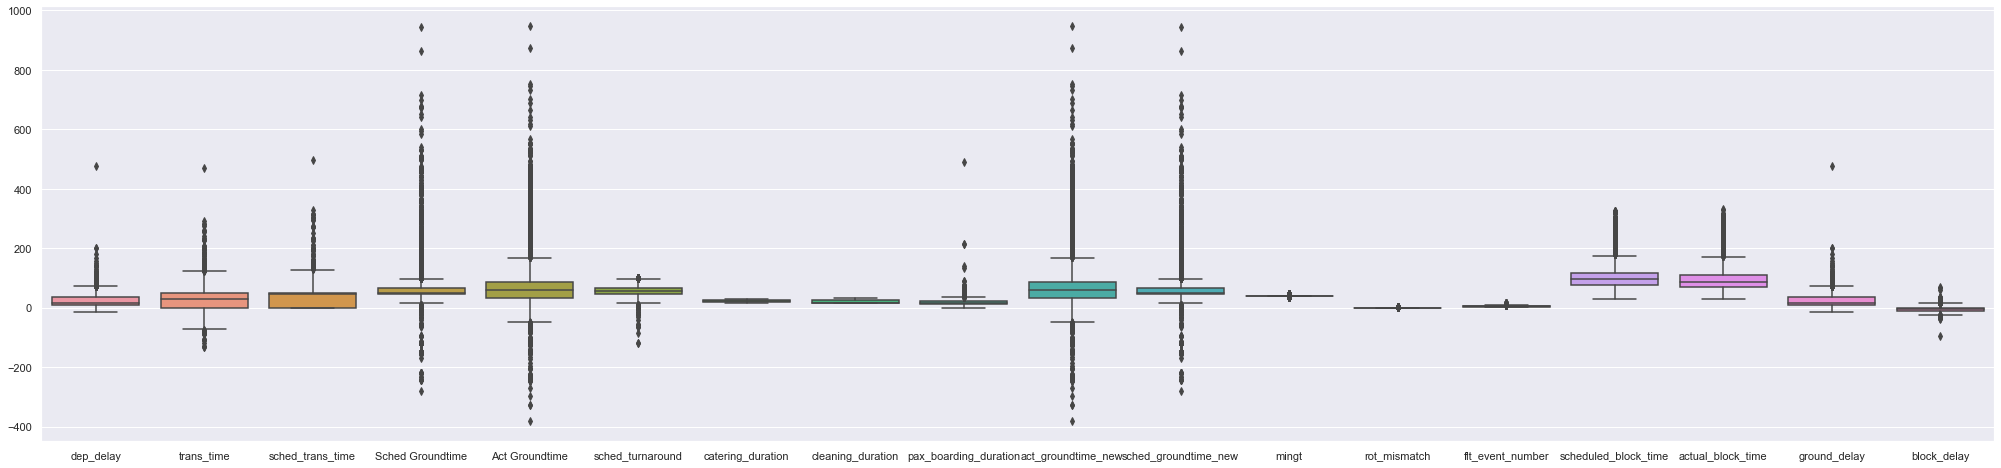

In [209]:
# Visualizing outliers

sns.set(rc={'figure.figsize':(35, 8)})
sns.boxplot(data = full_df.drop(['leg_no','leg_inbound', 'leg_outbound'], axis = 1))
full_df.describe()

This raises several questions for later analysis:
- Why do we have negative values for timedeltas? (Sched Groundtime, Act Groundtime, trans_time, sched_turnaround)
- Especially for sched_turnaround: Can this be correct? Misplanning of flights? 

## Duplicate Removal

Let's first check whether those are duplicates and whether removing them helps us. 

In [210]:
# We create an indicator whether we want to drop the corresponding row.
# This persists the order of the dataframe in case we need it later on

# We use the subset of leg_no as this is the closest we can get to a data-inherent identifier. If there are dupes in this subset, it is highly likely that the whole row is not reliable.
full_df["rows_to_drop"] = np.where(full_df.duplicated(subset = ['leg_no'], keep = False) == True, 1,0)
full_df['rows_to_drop'].value_counts()

0    11937
1      164
Name: rows_to_drop, dtype: int64

In [211]:
# Should we keep some observations of the dupes or none at all?

full_df[full_df['rows_to_drop'] == 1].head()

# Scoping thourgh this data frame for a bit reveals that some observations are more likely than others, but often we cannot clearly identify the correct observation. 
# Consequently, we drop all duplicates and keep none of them. 

,leg_no,fn_number_x,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,fn_number_y,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,act_groundtime_new,sched_groundtime_new,mingt,rot_mismatch,flt_event_number,scheduled_block_time,actual_block_time,ground_delay,block_delay,rows_to_drop
1222,272218014,EC11525,East Allisontown,Aaronbury,2019-06-29,2019-06-29 16:25:00,2019-06-29,2019-06-29 17:05:00,2019-06-29 16:27:00,2019-06-29 17:07:00,ECLBJX,other problem,2.0,320,33,45,A,"['Erika Sandoval_232_33_45_cp', 'Julia Hollowa...",[],50.0,64.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,64.0,50.0,40.0,True,5,40.0,40.0,2.0,0.0,1
1223,272218014,EC11525,East Allisontown,Aaronbury,2019-06-29,2019-06-29 16:25:00,2019-06-29,2019-06-29 17:05:00,2019-06-29 16:28:00,2019-06-29 17:08:00,ECLBJX,other problem,3.0,320,0,0,Start,"['Robert Williams_nan_nan_nan_ca', 'Holly Cook...",[],50.0,50.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,40.0,False,6,40.0,40.0,3.0,0.0,1
1224,272101016,EC11525,Aaronbury,North Stephenville,2019-06-29,2019-06-29 17:55:00,2019-06-29,2019-06-29 20:30:00,2019-06-29 17:58:00,2019-06-29 20:20:00,ECLBJX,other problem,3.0,320,0,0,Start,"['Robert Williams_nan_nan_nan_ca', 'Holly Cook...",[],50.0,80.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,80.0,50.0,40.0,True,7,155.0,142.0,3.0,-13.0,1
1225,272101016,EC11525,Aaronbury,North Stephenville,2019-06-29,2019-06-29 17:55:00,2019-06-29,2019-06-29 20:30:00,2019-06-29 18:11:00,2019-06-29 20:33:00,ECLBJX,rotational problem,16.0,320,33,45,A,"['Erika Sandoval_232_33_45_cp', 'Julia Hollowa...",[],-155.0,-245.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,-245.0,-155.0,40.0,False,8,155.0,142.0,16.0,-13.0,1
1387,272088110,EC11860,New Stacyburgh,East Michael,2019-06-27,2019-06-27 08:50:00,2019-06-27,2019-06-27 09:45:00,2019-06-27 08:53:00,2019-06-27 09:59:00,ECLBKX,other problem,3.0,320,-49,45,A,"['Mary Jones_88_-49_45_ca', 'Justin Roth_88_-4...",[],45.0,34.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,34.0,45.0,40.0,True,3,55.0,66.0,3.0,11.0,1


c:\Users\Paul\.conda\envs\py310\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\Paul\.conda\envs\py310\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


,leg_no,dep_delay,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,act_groundtime_new,sched_groundtime_new,mingt,flt_event_number,scheduled_block_time,actual_block_time,ground_delay,block_delay,rows_to_drop
count,1.210100e+04,12101.000000,12101.000000,12101.000000,10088.000000,10026.000000,4229.000000,4.229000e+03,4.229000e+03,4229.000000,3.000000,3817.000000,10026.000000,10088.000000,12093.000000,12101.000000,12101.000000,12018.000000,12101.000000,12018.000000,12101.000000
mean,2.720519e+08,25.805884,27.815305,35.086770,61.185071,64.850289,56.066446,2.720601e+08,2.720432e+08,21.961693,21.505556,18.467645,64.850289,61.185071,39.270239,3.747542,99.731840,94.963222,25.805884,-4.671909,0.013553
std,9.604818e+04,25.596928,31.861892,31.448448,58.664128,72.572299,16.975623,9.904749e+04,9.309438e+04,4.324847,10.667400,11.913937,72.572299,58.664128,2.620482,2.104575,42.767636,41.575881,25.596928,7.861026,0.115629
min,2.719556e+08,-14.000000,-134.000000,0.000000,-280.000000,-383.000000,-120.000000,2.719558e+08,2.719560e+08,15.000000,14.000000,0.000000,-383.000000,-280.000000,35.000000,1.000000,30.000000,28.000000,-14.000000,-97.000000,0.000000
25%,2.719829e+08,10.000000,0.000000,0.000000,45.000000,33.000000,45.000000,2.719897e+08,2.719841e+08,18.000000,15.400000,13.000000,33.000000,45.000000,40.000000,2.000000,75.000000,68.000000,10.000000,-10.000000,0.000000
50%,2.720117e+08,17.000000,28.000000,45.000000,50.000000,59.000000,55.000000,2.720156e+08,2.720094e+08,22.000000,16.800000,17.000000,59.000000,50.000000,40.000000,4.000000,95.000000,87.000000,17.000000,-5.000000,0.000000
75%,2.721016e+08,35.000000,49.000000,50.000000,65.000000,87.000000,65.000000,2.721834e+08,2.720343e+08,26.000000,25.258333,22.000000,87.000000,65.000000,40.000000,5.000000,115.000000,110.000000,35.000000,0.000000,0.000000
max,2.723603e+08,476.000000,470.000000,495.000000,945.000000,947.000000,100.000000,2.723601e+08,2.723580e+08,29.000000,33.716667,491.000000,947.000000,945.000000,45.000000,15.000000,325.000000,333.000000,476.000000,71.000000,1.000000


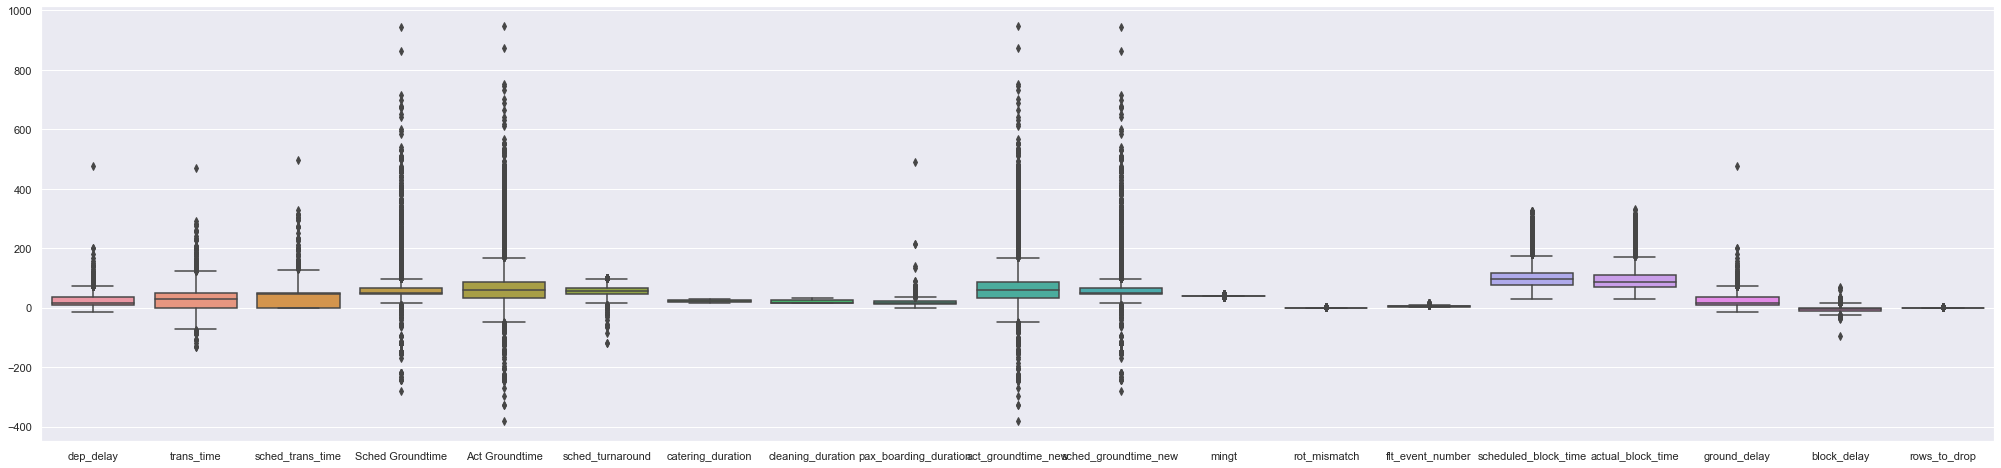

In [212]:
# Visualizing outliers again 

sns.set(rc={'figure.figsize':(35, 8)})
sns.boxplot(data = full_df.drop(['leg_no','leg_inbound', 'leg_outbound'], axis = 1))
full_df.describe()

We see that still many unexplainable negative values remain. We care about that later and first have a more intensive look on our NaNs.

Unique values per categorical feature

<AxesSubplot:title={'center':'Unique values per feature'}>

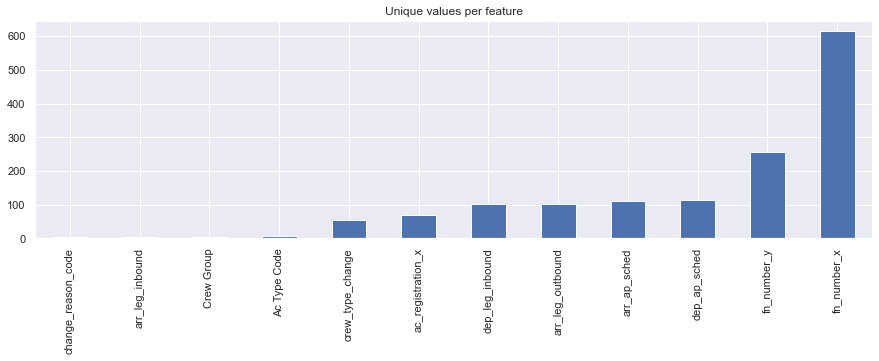

In [213]:
# Get unique values
unique_values = full_df.select_dtypes(include = 'object').nunique().sort_values().drop(['TLC_trans'])

# Plot
unique_values.plot.bar(figsize = (15,4), title = "Unique values per feature")

## NaN Analysis

Overall check of NaN Values

In [214]:
# Count the number of NAs per variable
na_count(full_df)

leg_no NAs: 0(0.0%)
fn_number_x NAs: 0(0.0%)
dep_ap_sched NAs: 0(0.0%)
arr_ap_sched NAs: 0(0.0%)
dep_sched_date NAs: 0(0.0%)
dep_sched_time NAs: 0(0.0%)
arr_sched_date NAs: 0(0.0%)
arr_sched_time NAs: 0(0.0%)
m_offblockdt NAs: 0(0.0%)
m_onblockdt NAs: 83(0.69%)
ac_registration_x NAs: 0(0.0%)
change_reason_code NAs: 0(0.0%)
dep_delay NAs: 0(0.0%)
Ac Type Code NAs: 8(0.07%)
trans_time NAs: 0(0.0%)
sched_trans_time NAs: 0(0.0%)
Crew Group NAs: 0(0.0%)
TLC_trans NAs: 0(0.0%)
crew_type_change NAs: 0(0.0%)
Sched Groundtime NAs: 2013(16.63%)
Act Groundtime NAs: 2075(17.15%)
day_of_origin NAs: 7872(65.05%)
fn_number_y NAs: 7872(65.05%)
dep_leg_inbound NAs: 7872(65.05%)
arr_leg_inbound NAs: 7872(65.05%)
arr_leg_outbound NAs: 7877(65.09%)
sched_inbound_dep NAs: 7872(65.05%)
sched_inbound_arr NAs: 7872(65.05%)
sched_outbound_dep NAs: 7872(65.05%)
sched_outbound_arr NAs: 7872(65.05%)
sched_turnaround NAs: 7872(65.05%)
leg_inbound NAs: 7872(65.05%)
leg_outbound NAs: 7872(65.05%)
catering_duration N

c:\Users\Paul\.conda\envs\py310\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
c:\Users\Paul\.conda\envs\py310\lib\site-packages\seaborn\matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


<AxesSubplot:>

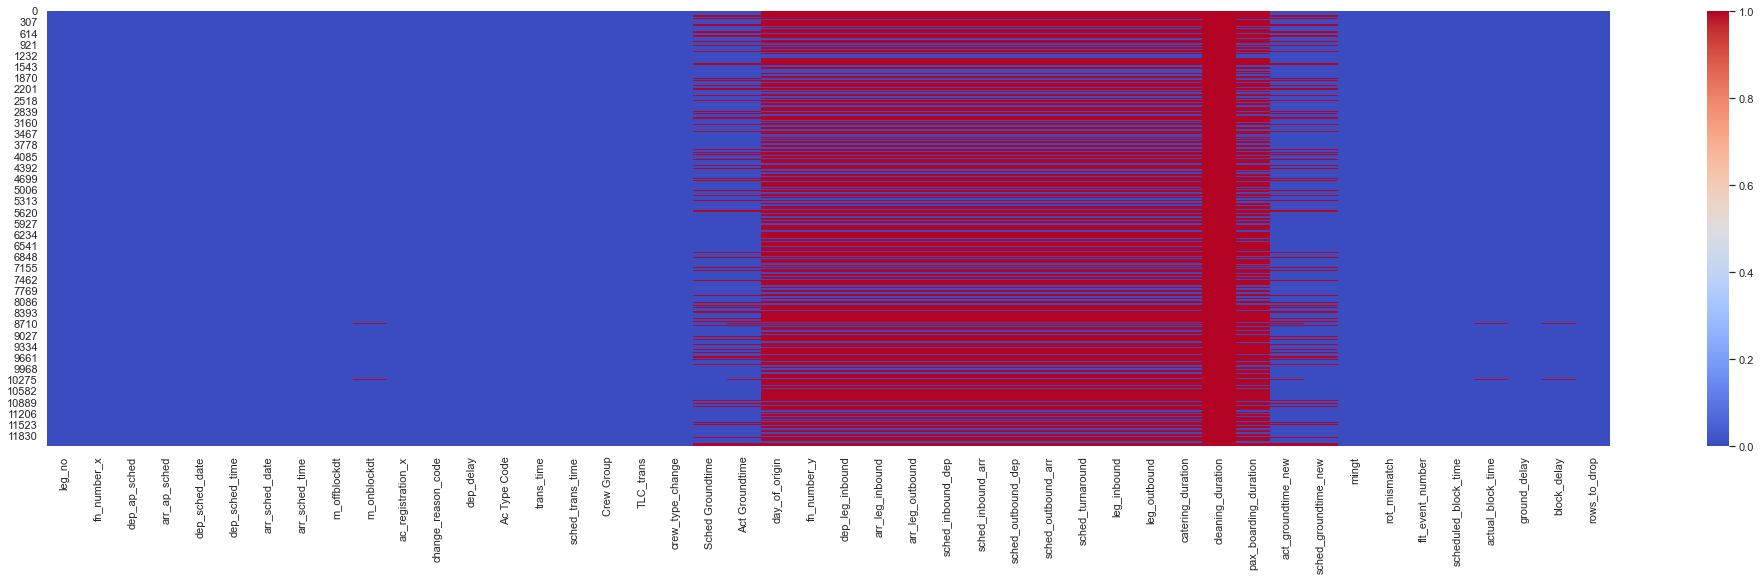

In [215]:
# visually

sns.heatmap(full_df[full_df['rows_to_drop'] == 0].isnull(), cmap='coolwarm')

Notes
We make the following notes:
- feature cleaning_duration can be dropped as it provides no additional knowledge (actually, it only has three observations)
- most NAs occur due to the ground data not having a match within the left join. This is expected as we only have ground data for East Carmen. 
- we still have a few NAs for m_onblockdt, Sched Groundtime and Act Groundtime. Those should be investigated. 

### Feature m_onblockdate

In [216]:
m_onblockdt_NA = full_df[(full_df['m_onblockdt'].isna() == True) & (full_df['rows_to_drop'] == 0 )]
m_onblockdt_NA

,leg_no,fn_number_x,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,fn_number_y,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,act_groundtime_new,sched_groundtime_new,mingt,rot_mismatch,flt_event_number,scheduled_block_time,actual_block_time,ground_delay,block_delay,rows_to_drop
15,272213772,EC3315,East Carmen,East Latashaview,2019-06-03,2019-06-03 18:15:00,2019-06-03,2019-06-03 21:40:00,2019-06-03 18:27:00,NaT,ECLBAX,other problem,12.0,321,0,0,Start,"['James Bailey_nan_nan_nan_ca', 'Brian Gomez_n...",[],NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,False,5,205.0,NaN,12.0,NaN,0
37,272023973,EC3287,East Carmen,New Jessica,2019-06-09,2019-06-09 08:20:00,2019-06-09,2019-06-09 11:25:00,2019-06-09 08:40:00,NaT,ECLBAX,other problem,20.0,321,91,85,B2,"['Lindsey Martinez_32_91_85_ca', 'Kristy Harpe...","['ca', 'cp', 'cp', 'ca', 'ca']",145.0,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.0,45.0,False,2,185.0,NaN,20.0,NaN,0
216,271962549,EC2627,East Carmen,Susanmouth,2019-06-12,2019-06-12 15:30:00,2019-06-12,2019-06-12 17:05:00,2019-06-12 16:53:00,NaT,ECLBBX,technical problem,83.0,321,50,60,C,"['Amy Reyes_243_50_60_cp', 'Lindsey Saunders_2...","['cp', 'ca', 'ca', 'cp']",45.0,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,45.0,False,5,95.0,NaN,83.0,NaN,0
567,272025160,EC3300,Coleland,East Carmen,2019-06-24,2019-06-24 02:25:00,2019-06-24,2019-06-24 04:00:00,2019-06-24 02:26:00,NaT,ECLBDX,other problem,1.0,322,0,0,Start,"['Barbara Stout_nan_nan_nan_ca', 'Stacey Green...",[],65.0,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,45.0,False,1,95.0,NaN,1.0,NaN,0
667,271968173,EC2680,West Jason,East Carmen,2019-06-12,2019-06-12 07:00:00,2019-06-12,2019-06-12 08:20:00,2019-06-12 07:02:00,NaT,ECLBEX,other problem,2.0,322,32,45,A,"['Grant Gonzalez_42_32_45_ca', 'Ariel Hall_42_...",[],0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,45.0,False,3,80.0,NaN,2.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11337,271977647,EC2761,East Carmen,North Jeffrey,2019-06-24,2019-06-24 15:35:00,2019-06-24,2019-06-24 17:20:00,2019-06-24 16:02:00,NaT,ECLXAX,rotational problem,27.0,320,34,55,A,"['Lindsey Hodges_251_34_55_ca', 'Bonnie Harrel...",[],45.0,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,40.0,False,5,105.0,NaN,27.0,NaN,0
11693,271987568,EC2882,Navarroville,East Carmen,2019-06-21,2019-06-21 13:05:00,2019-06-21,2019-06-21 14:45:00,2019-06-21 13:05:00,NaT,ECLXCX,no reason,0.0,320,21,40,A,"['Christina Valdez_156_21_40_ca', 'Lynn Murphy...",[],200.0,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.0,40.0,False,4,100.0,NaN,0.0,NaN,0
11791,272184352,EC2630,Susanmouth,East Carmen,2019-06-08,2019-06-08 13:05:00,2019-06-08,2019-06-08 14:40:00,2019-06-08 13:05:00,NaT,ECLXDX,no reason,0.0,320,42,45,A,"['Kenneth Morrow_nan_nan_nan_ca', 'Teresa Bair...",['ca'],60.0,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,40.0,False,4,95.0,NaN,0.0,NaN,0
11808,271957520,EC2579,East Carmen,Lake Lawrencechester,2019-06-11,2019-06-11 10:10:00,2019-06-11,2019-06-11 11:40:00,2019-06-11 10:34:00,NaT,ECLXDX,other problem,24.0,320,114,105,B2,"['Daniel Young_90_114_105_ca', 'Mathew Andrade...","['ca', 'cp', 'cp', 'ca', 'ca']",70.0,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0,40.0,False,3,90.0,NaN,24.0,Na

c:\Users\Paul\.conda\envs\py310\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
c:\Users\Paul\.conda\envs\py310\lib\site-packages\seaborn\matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


<AxesSubplot:>

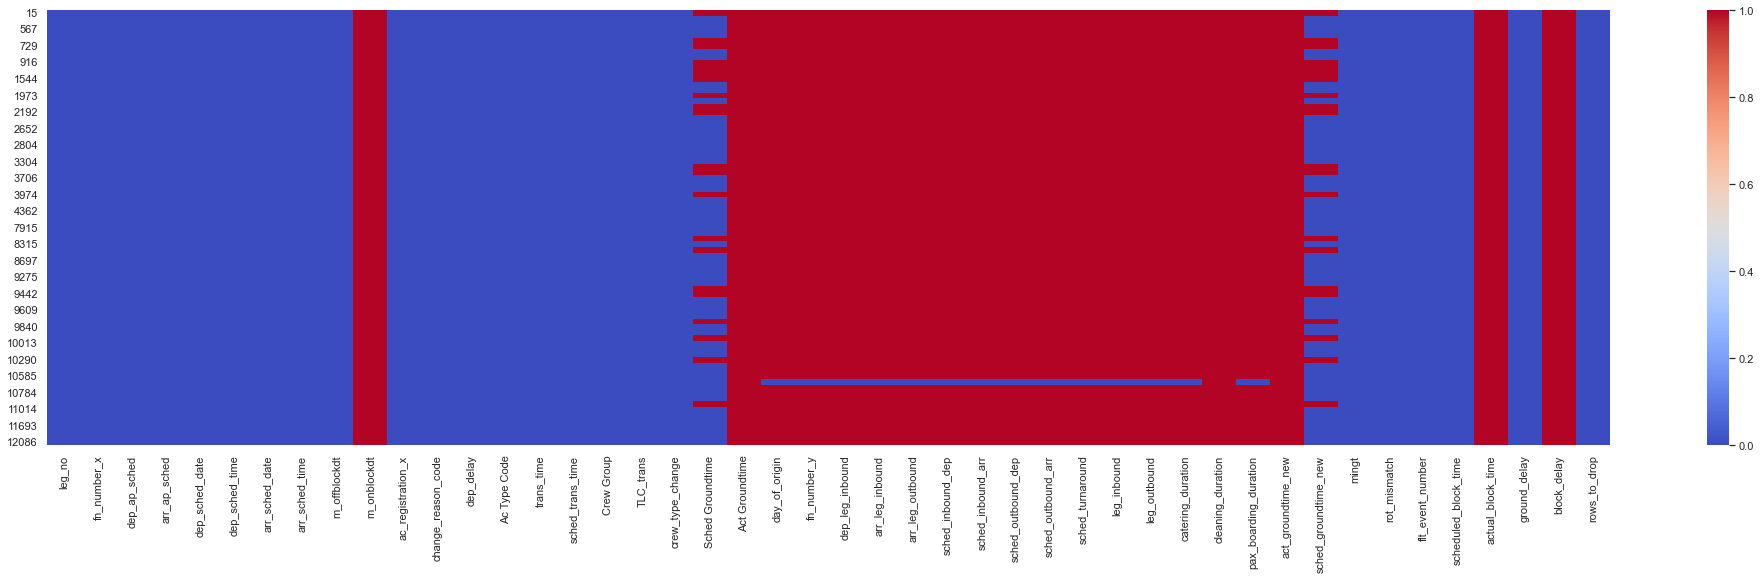

In [217]:
sns.heatmap(m_onblockdt_NA.isnull(), cmap='coolwarm')

Notes
- Whenever m_onblockdt is NaT, Act Groundtime is also NA. 
- This might indicate that there was a flight irregularity and the flight did not depart and consequently had no onblock at the arrival. 
- However, at a certain point, flight delay can also be such huge irregularity that a flight is cancelled although this happens seldomly. 
Regardless the reason, we are talking about 79 observations, having some 12'000 observations, so further in depth analysis might be interesting at a later stage, but not now. 
We consequently drop those rows as well.



In [218]:
# Mark m_onblockdt NAs for dropping

print(full_df['rows_to_drop'].sum())
full_df["rows_to_drop"] = np.where(full_df['m_onblockdt'].isna() == True, 1, full_df["rows_to_drop"])
print(full_df['rows_to_drop'].sum())


164
243


Checking NAs again

- We see that only Sched Groundtime and Act Groundtime still have NAs (Looking at the flight dataset)

In [219]:
na_count(full_df[full_df['rows_to_drop'] == 0])

leg_no NAs: 0(0.0%)
fn_number_x NAs: 0(0.0%)
dep_ap_sched NAs: 0(0.0%)
arr_ap_sched NAs: 0(0.0%)
dep_sched_date NAs: 0(0.0%)
dep_sched_time NAs: 0(0.0%)
arr_sched_date NAs: 0(0.0%)
arr_sched_time NAs: 0(0.0%)
m_offblockdt NAs: 0(0.0%)
m_onblockdt NAs: 0(0.0%)
ac_registration_x NAs: 0(0.0%)
change_reason_code NAs: 0(0.0%)
dep_delay NAs: 0(0.0%)
Ac Type Code NAs: 8(0.07%)
trans_time NAs: 0(0.0%)
sched_trans_time NAs: 0(0.0%)
Crew Group NAs: 0(0.0%)
TLC_trans NAs: 0(0.0%)
crew_type_change NAs: 0(0.0%)
Sched Groundtime NAs: 1992(16.8%)
Act Groundtime NAs: 1992(16.8%)
day_of_origin NAs: 7742(65.29%)
fn_number_y NAs: 7742(65.29%)
dep_leg_inbound NAs: 7742(65.29%)
arr_leg_inbound NAs: 7742(65.29%)
arr_leg_outbound NAs: 7747(65.33%)
sched_inbound_dep NAs: 7742(65.29%)
sched_inbound_arr NAs: 7742(65.29%)
sched_outbound_dep NAs: 7742(65.29%)
sched_outbound_arr NAs: 7742(65.29%)
sched_turnaround NAs: 7742(65.29%)
leg_inbound NAs: 7742(65.29%)
leg_outbound NAs: 7742(65.29%)
catering_duration NAs: 

### Features Sched Groundtime and Act Groundtime 

Hypothesis: If Sched Groundtime is NA, Act Groundtime is also NA


c:\Users\Paul\.conda\envs\py310\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
c:\Users\Paul\.conda\envs\py310\lib\site-packages\seaborn\matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


<AxesSubplot:>

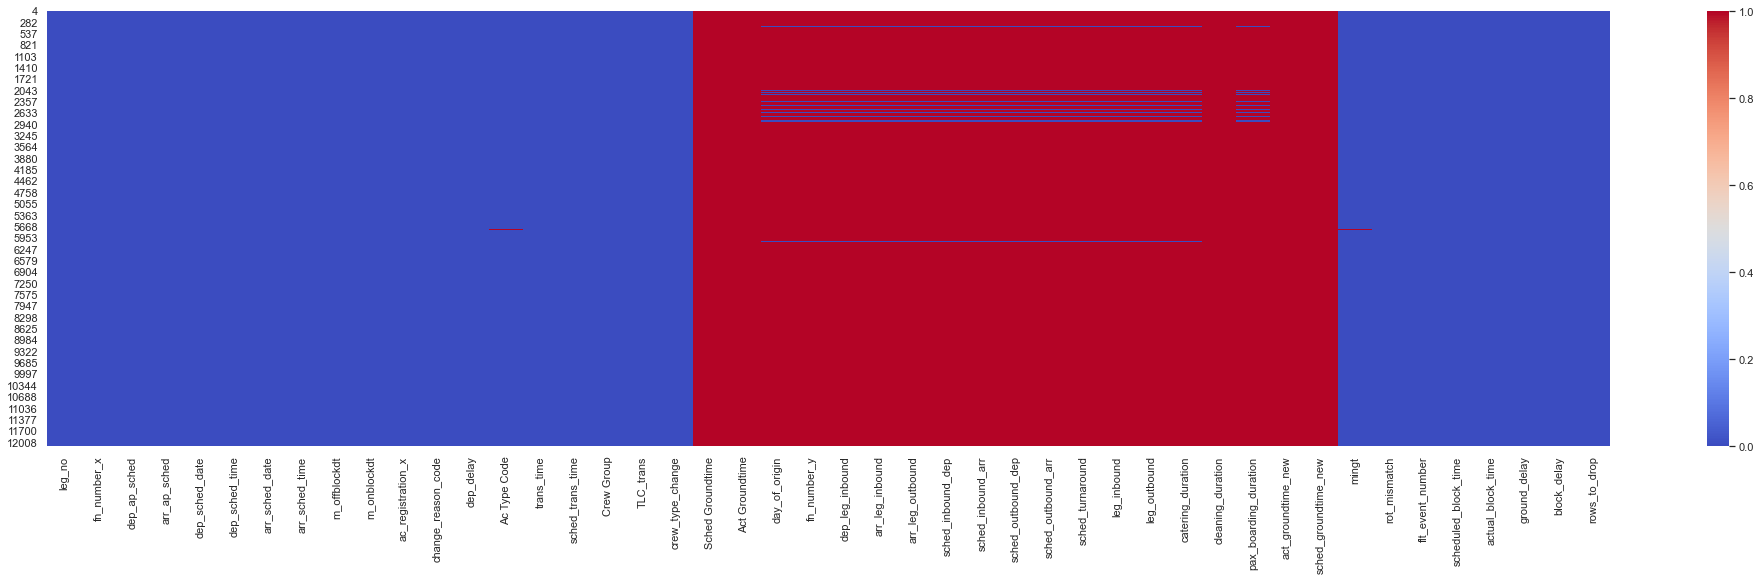

In [220]:
#Hypothesis 1:
full_df_NA = full_df[full_df.drop(['cleaning_duration', 'pax_boarding_duration'], axis = 1).isna().any(axis = 1)] # Filter out Rows w/o NA
full_df_NA = full_df_NA[full_df_NA['rows_to_drop'] == 0] # Filter out rows which will be dropped
full_df_NA = full_df_NA[full_df_NA['Sched Groundtime'].isna()] # Only keep rows which have NA for Sched Groundtime
sns.heatmap(full_df_NA.isnull(), cmap='coolwarm') # visualize

In [221]:
full_df_NA.describe()

,leg_no,dep_delay,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,act_groundtime_new,sched_groundtime_new,mingt,flt_event_number,scheduled_block_time,actual_block_time,ground_delay,block_delay,rows_to_drop
count,1.992000e+03,1992.000000,1992.000000,1992.000000,0.0,0.0,31.000000,3.100000e+01,3.100000e+01,31.000000,0.0,29.000000,0.0,0.0,1985.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.0
mean,2.720470e+08,12.958333,27.756526,40.193273,NaN,NaN,57.096774,2.720305e+08,2.720263e+08,23.612903,NaN,15.827586,NaN,NaN,39.377834,6.009538,102.424699,98.831325,12.958333,-3.593373,0.0
std,9.362414e+04,8.606573,32.943226,31.200254,NaN,NaN,35.818389,3.668197e+04,9.462261e+04,3.972215,NaN,5.332307,NaN,NaN,2.675929,1.707492,48.665200,47.421602,8.606573,8.882758,0.0
min,2.719565e+08,0.000000,-110.000000,0.000000,NaN,NaN,-65.000000,2.719580e+08,2.719571e+08,15.000000,NaN,7.000000,NaN,NaN,35.000000,1.000000,35.000000,28.000000,0.000000,-38.000000,0.0
25%,2.719802e+08,3.000000,0.000000,0.000000,NaN,NaN,50.000000,2.720284e+08,2.719680e+08,21.500000,NaN,14.000000,NaN,NaN,40.000000,5.000000,75.000000,68.000000,3.000000,-9.000000,0.0
50%,2.720048e+08,15.000000,28.000000,45.000000,NaN,NaN,60.000000,2.720284e+08,2.719854e+08,24.000000,NaN,16.000000,NaN,NaN,40.000000,6.000000,95.000000,89.000000,15.000000,-4.000000,0.0
75%,2.720995e+08,19.000000,51.000000,55.000000,NaN,NaN,80.000000,2.720284e+08,2.720101e+08,26.500000,NaN,17.000000,NaN,NaN,40.000000,7.000000,115.000000,115.000000,19.000000,1.000000,0.0
max,2.723603e+08,59.000000,228.000000,330.000000,NaN,NaN,100.000000,2.722134e+08,2.722318e+08,29.000000,NaN,34.000000,NaN,NaN,45.000000,15.000000,305.000000,303.000000,59.000000,58.000000,0.0


Scheduled Groundtime and Actual Groundtime have the same number of NAs. As both variables have no values in the dataset where Sched Groundtime NAs are displayed, all Sched Groundtime NAs have NAs for Act Groundtime as well. 

Sched Groundtime NAs nearly exclusively appear if the flight is the last flight of the day

c:\Users\Paul\.conda\envs\py310\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
c:\Users\Paul\.conda\envs\py310\lib\site-packages\seaborn\matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


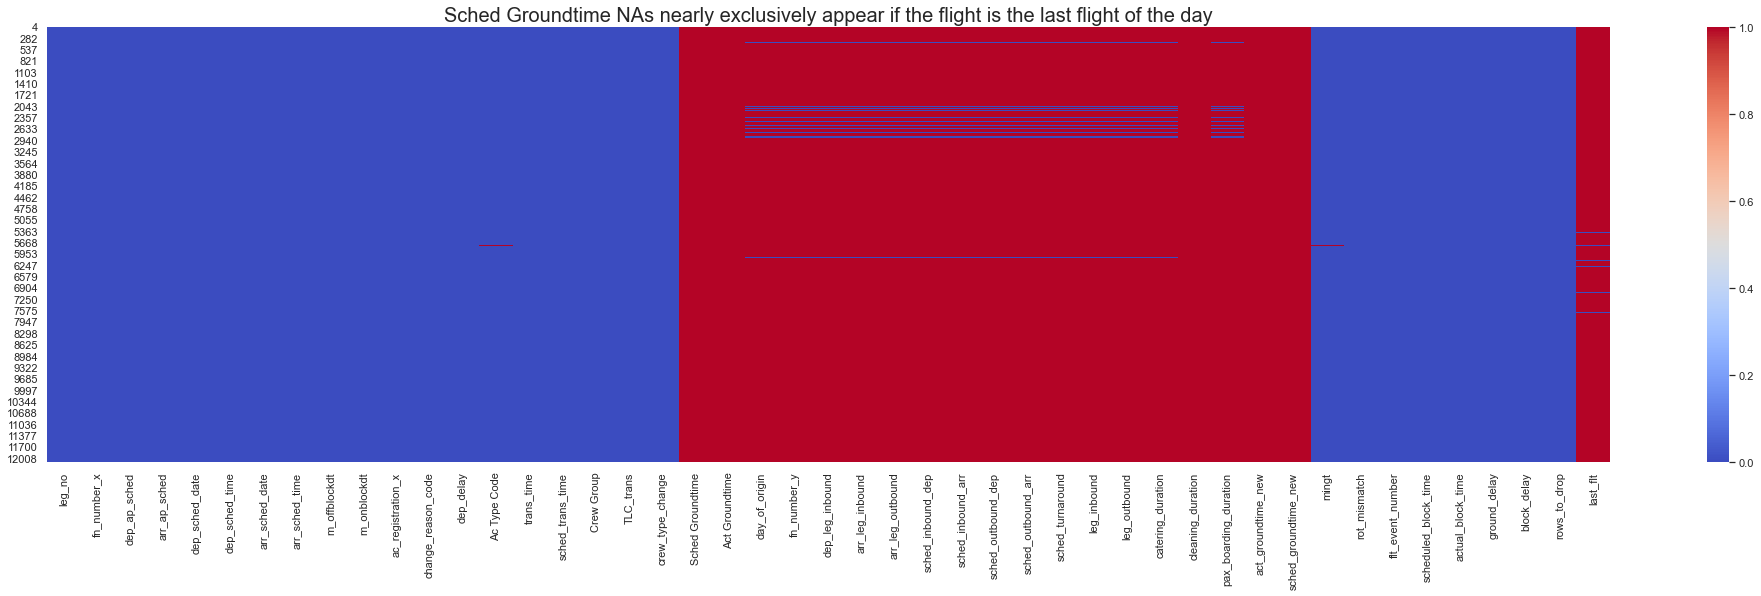

25 observations have NAs for Sched Groundtime while they are not the last flight of a given day.
1967 observations have NAs for Sched Groundtime while they are the last flight of a given day.


In [222]:
temp = full_df.copy()

# Create indicator for last flight of day
temp['last_flt'] = np.where(temp['flt_event_number'].shift(-1).ge(temp['flt_event_number']) == True,
    0,
    np.nan
)

#temp.head(10)


temp = temp[temp['rows_to_drop'] == 0] # Filter out rows which will be dropped
temp = temp[temp['Sched Groundtime'].isna()] # Only keep rows which have NA for Sched Groundtime
plt.title("Sched Groundtime NAs nearly exclusively appear if the flight is the last flight of the day", fontsize = 20)
sns.heatmap(temp.isnull(), cmap='coolwarm') # visualize
plt.show()

# Count Sched Groundtime NAs which are not the last flight of a given day 
print(str(temp[temp['last_flt'] == 0]['leg_no'].count()) + " observations have NAs for Sched Groundtime while they are not the last flight of a given day.")
print(str(temp[temp['last_flt'] != 0]['leg_no'].count()) + " observations have NAs for Sched Groundtime while they are the last flight of a given day.")

- As we only predict landing times, the last ground time on a given day has no meaning for us in any case
- We can consequently drop those rows for the ground delay prediction
- However, we can still use them for the block time delay calculations as block time is in its calculation not impacted by ground time. 

&rarr; Consequently, we create another colum indicating additional rows to drop for the ground delay calculation. 

*Belated disclaimer*: These ideas were created when I still followed the plan of separating block delay and ground delay calculation. As this was merged later on, the marking of additional rows to drop for ground delay is not neccessary anymore.

In [223]:
# Create Feature for additional rows to drop for ground delay prediction
full_df['rows_to_drop_grounddelay'] = np.where(full_df['Sched Groundtime'].isna() == True, 1, 0)

full_df['rows_to_drop_grounddelay'].sum()

2013

Checking Last Flights that *do* have a ground time

c:\Users\Paul\.conda\envs\py310\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
c:\Users\Paul\.conda\envs\py310\lib\site-packages\seaborn\matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


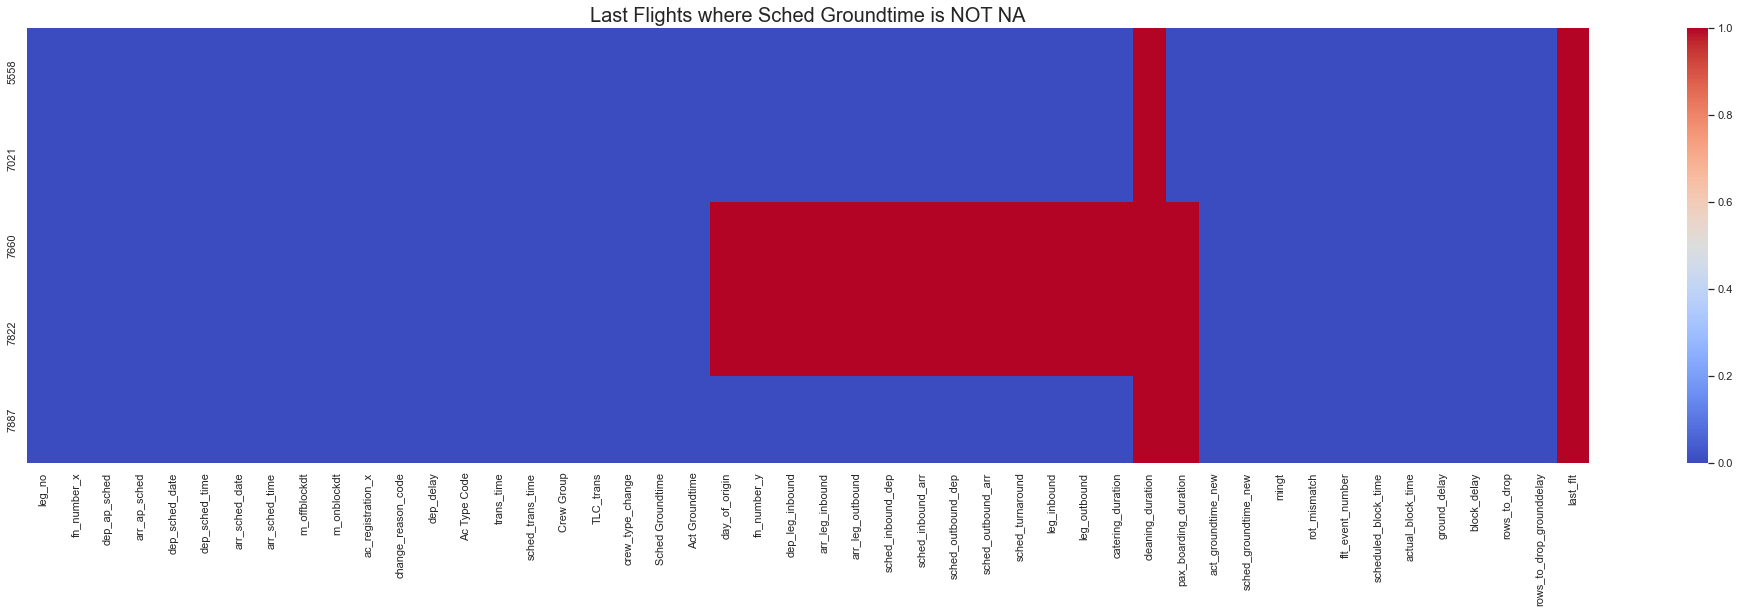

,leg_no,fn_number_x,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,fn_number_y,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,act_groundtime_new,sched_groundtime_new,mingt,rot_mismatch,flt_event_number,scheduled_block_time,actual_block_time,ground_delay,block_delay,rows_to_drop,rows_to_drop_grounddelay,last_flt
5558,272011137,EC3168,North Anna,East Carmen,2019-06-28,2019-06-28 19:20:00,2019-06-28,2019-06-28 20:10:00,2019-06-29 03:16:00,2019-06-29 03:57:00,ECLGBX,other problem,476.0,DH4,15,30,A,"['Destiny Sanchez_355_15_30_cp', 'Cynthia John...",[],65.0,-383.0,2019-06-28,EC3168,North Anna,East Carmen,East Carmen,2019-06-28 19:20:00,2019-06-28 20:10:00,2019-06-28 21:15:00,2019-06-28 22:30:00,65.0,272011137.0,271984461.0,18.0,NaN,491.0,-383.0,65.0,35.0,False,11,50.0,41.0,476.0,-9.0,0,0,NaN
7021,272214805,EC3358,Fisherhaven,East Carmen,2019-06-08,2019-06-08 16:50:00,2019-06-08,2019-06-08 17:50:00,2019-06-08 19:49:00,2019-06-08 20:46:00,ECLGMX,rotational problem,179.0,DH4,26,40,C,"['William Noble_262_26_40_ca', 'Kenneth Ruiz_2...","['ca', 'cp', 'ca']",25.0,-128.0,2019-06-08,EC3358,Fisherhaven,East Carmen,Port Courtneytown,2019-06-08 16:50:00,2019-06-08 17:50:00,2019-06-08 18:15:00,2019-06-08 19:00:00,25.0,272214805.0,272032376.0,28.0,NaN,19.0,-128.0,25.0,35.0,True,8,60.0,57.0,179.0,-3.0,0,0,NaN
7660,272012162,EC3177,East Carmen,Lake Kevin,2019-06-28,2019-06-28 15:20:00,2019-06-28,2019-06-28 16:05:00,2019-06-28 17:41:00,2019-06-28 18:23:00,ECLGQX,technical problem,141.0,DHX,280,315,C,"['Matthew Valdez_nan_nan_nan_cp', 'Derek Sween...",['cp'],40.0,-76.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,-76.0,40.0,35.0,True,7,45.0,42.0,141.0,-3.0,0,0,NaN
7822,272010930,EC3167,East Carmen,North Anna,2019-06-19,2019-06-19 18:00:00,2019-06-19,2019-06-19 18:50:00,2019-06-19 19:30:00,2019-06-19 20:14:00,ECLGRX,technical problem,90.0,DHX,16,40,A,"['Jacqueline Wright_322_16_40_ca', 'Erica King...",[],30.0,-53.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,-53.0,30.0,35.0,True,9,50.0,44.0,90.0,-6.0,0,0,NaN
7887,272004657,EC3088,Paulbury,East Carmen,2019-06-30,2019-06-30 17:50:00,2019-06-30,2019-06-30 19:05:00,2019-06-30 20:00:00,2019-06-30 21:34:00,ECLGRX,technical problem,130.0,DHX,14,45,A,"['Gary Buchanan_293_14_45_ca', 'Matthew Harper...",[],20.0,-111.0,2019-06-30,EC3088,Paulbury,East Carmen,Lake Kevin,2019-06-30 17:50:00,2019-06-30 19:05:00,2019-06-30 19:25:00,2019-06-30 20:15:00,20.0,272004657.0,272011748.0,29.0,NaN,NaN,-111.0,20.0,35.0,False,4,75.0,94.0,130.0,19.0,0,0,NaN


In [224]:
temp = full_df.copy()

# Create indicator for last flight of day
temp['last_flt'] = np.where(temp['flt_event_number'].shift(-1).ge(temp['flt_event_number']) == True,
    0,
    np.nan
)

temp = temp[(temp['rows_to_drop'] == 0) & (temp['rows_to_drop_grounddelay'] == 0)] # Filter out rows which will be dropped
temp = temp[temp['last_flt'].isna()] # Only keep rows of last flight
plt.title("Last Flights where Sched Groundtime is NOT NA", fontsize = 20)
sns.heatmap(temp.isnull(), cmap='coolwarm') # visualize
plt.show()

temp

Interestingly enough, we have five observations which are a last flight but do actually have values for Groundtime. This looks strange. We drop the rows as they also have negative values for Act Groundtime, which can't be. 

In [225]:
# for this we also must create last_flt for full_df
full_df['last_flt'] = np.where(full_df['flt_event_number'].shift(-1).ge(full_df['flt_event_number']) == True,
    0,
    np.nan
)

# mark rows to drop 
full_df['rows_to_drop_grounddelay'] = np.where(full_df['last_flt'].isna() == False, full_df['rows_to_drop_grounddelay'], 1)
full_df['rows_to_drop_grounddelay'].sum()

2018

Remaining NAs

In [226]:
na_count(full_df[(full_df['rows_to_drop'] == 0)  & (full_df['rows_to_drop_grounddelay'] == 0 )])

leg_no NAs: 0(0.0%)
fn_number_x NAs: 0(0.0%)
dep_ap_sched NAs: 0(0.0%)
arr_ap_sched NAs: 0(0.0%)
dep_sched_date NAs: 0(0.0%)
dep_sched_time NAs: 0(0.0%)
arr_sched_date NAs: 0(0.0%)
arr_sched_time NAs: 0(0.0%)
m_offblockdt NAs: 0(0.0%)
m_onblockdt NAs: 0(0.0%)
ac_registration_x NAs: 0(0.0%)
change_reason_code NAs: 0(0.0%)
dep_delay NAs: 0(0.0%)
Ac Type Code NAs: 1(0.01%)
trans_time NAs: 0(0.0%)
sched_trans_time NAs: 0(0.0%)
Crew Group NAs: 0(0.0%)
TLC_trans NAs: 0(0.0%)
crew_type_change NAs: 0(0.0%)
Sched Groundtime NAs: 0(0.0%)
Act Groundtime NAs: 0(0.0%)
day_of_origin NAs: 5779(58.6%)
fn_number_y NAs: 5779(58.6%)
dep_leg_inbound NAs: 5779(58.6%)
arr_leg_inbound NAs: 5779(58.6%)
arr_leg_outbound NAs: 5784(58.66%)
sched_inbound_dep NAs: 5779(58.6%)
sched_inbound_arr NAs: 5779(58.6%)
sched_outbound_dep NAs: 5779(58.6%)
sched_outbound_arr NAs: 5779(58.6%)
sched_turnaround NAs: 5779(58.6%)
leg_inbound NAs: 5779(58.6%)
leg_outbound NAs: 5779(58.6%)
catering_duration NAs: 5779(58.6%)
cleanin

We see no further NAs for the initial flight dataset. The NAs for the ground dataset make sense as we did a left join and we only have ground data for East Carmen. The NAs there are the out stations. 

## Block Time Check

In [227]:
full_df.describe()

,leg_no,dep_delay,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,act_groundtime_new,sched_groundtime_new,mingt,flt_event_number,scheduled_block_time,actual_block_time,ground_delay,block_delay,rows_to_drop,rows_to_drop_grounddelay,last_flt
count,1.210100e+04,12101.000000,12101.000000,12101.000000,10088.000000,10026.000000,4229.000000,4.229000e+03,4.229000e+03,4229.000000,3.000000,3817.000000,10026.000000,10088.000000,12093.000000,12101.000000,12101.000000,12018.000000,12101.000000,12018.000000,12101.000000,12101.000000,10108.0
mean,2.720519e+08,25.805884,27.815305,35.086770,61.185071,64.850289,56.066446,2.720601e+08,2.720432e+08,21.961693,21.505556,18.467645,64.850289,61.185071,39.270239,3.747542,99.731840,94.963222,25.805884,-4.671909,0.020081,0.166763,0.0
std,9.604818e+04,25.596928,31.861892,31.448448,58.664128,72.572299,16.975623,9.904749e+04,9.309438e+04,4.324847,10.667400,11.913937,72.572299,58.664128,2.620482,2.104575,42.767636,41.575881,25.596928,7.861026,0.140283,0.372780,0.0
min,2.719556e+08,-14.000000,-134.000000,0.000000,-280.000000,-383.000000,-120.000000,2.719558e+08,2.719560e+08,15.000000,14.000000,0.000000,-383.000000,-280.000000,35.000000,1.000000,30.000000,28.000000,-14.000000,-97.000000,0.000000,0.000000,0.0
25%,2.719829e+08,10.000000,0.000000,0.000000,45.000000,33.000000,45.000000,2.719897e+08,2.719841e+08,18.000000,15.400000,13.000000,33.000000,45.000000,40.000000,2.000000,75.000000,68.000000,10.000000,-10.000000,0.000000,0.000000,0.0
50%,2.720117e+08,17.000000,28.000000,45.000000,50.000000,59.000000,55.000000,2.720156e+08,2.720094e+08,22.000000,16.800000,17.000000,59.000000,50.000000,40.000000,4.000000,95.000000,87.000000,17.000000,-5.000000,0.000000,0.000000,0.0
75%,2.721016e+08,35.000000,49.000000,50.000000,65.000000,87.000000,65.000000,2.721834e+08,2.720343e+08,26.000000,25.258333,22.000000,87.000000,65.000000,40.000000,5.000000,115.000000,110.000000,35.000000,0.000000,0.000000,0.000000,0.0
max,2.723603e+08,476.000000,470.000000,495.000000,945.000000,947.000000,100.000000,2.723601e+08,2.723580e+08,29.000000,33.716667,491.000000,947.000000,945.000000,45.000000,15.000000,325.000000,333.000000,476.000000,71.000000,1.000000,1.000000,0.0


Notes

We see that neither scheduled block time nur actual block time have negative values or extremenly differing dispersions. We consequently take them as True.

## Negative Ground Time Check

Theoretically, as we in the meantime got the information that we can concentrate on forecasting delay (i.e., we are provided the full schedule during prediction). Consequently, we do not need to care as much about negative ground times as we might have needed before - analysis shows that the delay itself, so the difference in between scheduled and actual groundtime - looks quite ok.

Nevertheless, we want to have a look at negative gound times to better understand the data and maybe even improve overall data quality by a bit. 

### Negative Scheduled Ground Time

In [228]:
neg_sched_groundtime = full_df[(full_df['Sched Groundtime']<1) & (full_df['rows_to_drop'] == 0)  & (full_df['rows_to_drop_grounddelay'] == 0 )]
neg_sched_groundtime.shape
# So generally, we only have few rows which still have negative scheduled groundtime. 

(24, 48)

In [229]:
# Let's have a look at the observations and surrounding flights
# get indices of negative scheduled ground time
idx = neg_sched_groundtime.index

# Going through the rows
i = 8
full_df.iloc[idx[i]-1 : idx[i]+2]

,leg_no,fn_number_x,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,fn_number_y,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,act_groundtime_new,sched_groundtime_new,mingt,rot_mismatch,flt_event_number,scheduled_block_time,actual_block_time,ground_delay,block_delay,rows_to_drop,rows_to_drop_grounddelay,last_flt
2521,271981275,EC2808,South Loriview,East Carmen,2019-06-12,2019-06-12 08:15:00,2019-06-12,2019-06-12 10:00:00,2019-06-12 08:40:00,2019-06-12 10:18:00,ECLBRX,other problem,25.0,320,57,80,A,"['Cindy Jackson DVM_62_57_80_cp', 'Charlotte J...",[],50.0,44.0,2019-06-12,EC2808,South Loriview,East Carmen,Kennethfort,2019-06-12 08:15:00,2019-06-12 10:00:00,2019-06-12 10:50:00,2019-06-12 12:50:00,50.0,271981275.0,272194166.0,23.0,NaN,12.0,44.0,50.0,40.0,False,2,105.0,98.0,25.0,-7.0,0,0,0.0
2522,272194166,EC2871,East Carmen,Kennethfort,2019-06-12,2019-06-12 10:50:00,2019-06-12,2019-06-12 12:50:00,2019-06-12 11:02:00,2019-06-12 13:03:00,ECLBRX,other problem,12.0,320,0,0,Start,"['Shannon Schmidt_nan_nan_nan_cp', 'Eric Smith...",[],-95.0,-57.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,-57.0,-95.0,40.0,True,3,120.0,121.0,12.0,1.0,0,0,0.0
2523,272175534,EC3327,East Carmen,South Haileyberg,2019-06-12,2019-06-12 11:15:00,2019-06-12,2019-06-12 15:35:00,2019-06-12 12:06:00,2019-06-12 16:14:00,ECLBRX,rotational problem,51.0,320,0,0,Start,"['Jeffrey Davis_nan_nan_nan_cp', 'Scott Cox_na...",[],-120.0,-157.0,2019-06-12,EC3327,East Carmen,South Haileyberg,East Carmen,2019-06-12 11:15:00,2019-06-12 15:35:00,2019-06-12 13:35:00,2019-06-12 15:35:00,-120.0,272175534.0,271986377.0,26.0,33.716667,NaN,-157.0,-120.0,40.0,True,4,260.0,248.0,51.0,-12.0,0,0,0.0


Notes 

So this is an interesting one. Skimming through all cases, we see that they are indeed correctly calculated, it simply looks like a mistake done by scheduling - but the data itself is correct. 

In general, we should predict delay, and scheduling mistakes can cause delay. However, it is unlikely that scheduling would do such mistake. We consequently drop those rows. 

In [230]:
full_df.loc[idx,"rows_to_drop"] = 1

### Negative Actual Ground Time

We cannot find any reason for negative actual ground time. 

In [231]:
neg_act_groundtime = full_df[(full_df['Act Groundtime']<1) & (full_df['rows_to_drop'] == 0)  & (full_df['rows_to_drop_grounddelay'] == 0 )]
neg_act_groundtime.shape

(945, 48)

In [232]:
# Let's have a look at the observations and surrounding flights
# get indices of negative scheduled ground time
idx = neg_act_groundtime.index

# Going through the rows
i=10
full_df.iloc[idx[i]-1 : idx[i]+2]

,leg_no,fn_number_x,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,fn_number_y,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,act_groundtime_new,sched_groundtime_new,mingt,rot_mismatch,flt_event_number,scheduled_block_time,actual_block_time,ground_delay,block_delay,rows_to_drop,rows_to_drop_grounddelay,last_flt
224,272023978,EC3287,East Carmen,New Jessica,2019-06-14,2019-06-14 08:20:00,2019-06-14,2019-06-14 11:25:00,2019-06-14 09:28:00,2019-06-14 12:28:00,ECLBBX,technical problem,68.0,321,44,60,B2,"['Jacqueline Roberts_nan_nan_nan_ca', 'Angela ...","['cp', 'cp', 'ca', 'ca', 'ca']",145.0,187.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,187.0,145.0,45.0,False,2,185.0,180.0,68.0,-5.0,0,0,0.0
225,272024188,EC3288,New Jessica,East Carmen,2019-06-14,2019-06-14 13:50:00,2019-06-14,2019-06-14 17:15:00,2019-06-14 15:35:00,2019-06-14 18:48:00,ECLBBX,technical problem,105.0,321,0,0,Start,"['Aaron Williams_nan_nan_nan_ca', 'Alison Will...",[],80.0,0.0,2019-06-14,EC3288,New Jessica,East Carmen,Susanmouth,2019-06-14 13:50:00,2019-06-14 17:15:00,2019-06-14 18:35:00,2019-06-14 20:05:00,80.0,272024188.0,271962131.0,28.0,NaN,0.0,0.0,80.0,45.0,False,3,205.0,193.0,105.0,-12.0,0,0,0.0
226,271962131,EC2623,East Carmen,Susanmouth,2019-06-14,2019-06-14 18:35:00,2019-06-14,2019-06-14 20:05:00,2019-06-14 18:48:00,2019-06-14 20:17:00,ECLBBX,other problem,13.0,321,41,80,A,"['Ruth Prince_nan_nan_nan_ca', 'Karen Garcia D...","['ca', 'ca', 'cp', 'ca', 'cp']",NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,False,4,90.0,89.0,13.0,-1.0,0,1,NaN


In [233]:
# No findings.. 

In [234]:
# Let's check whether we have higher values of negative Act Groundtime for certain A/C-types:

full_df['Neg_Act_Groundtime'] = np.where(full_df['Act Groundtime']<0,'Yes','No')


pd.pivot_table(
    data = full_df[(full_df['rows_to_drop']==0) & (full_df['rows_to_drop_grounddelay']==0)], 
    index = ['Ac Type Code'], 
    values = ['ac_registration_x'], 
    columns = ['Neg_Act_Groundtime'], 
    aggfunc = len
    )

ac_registration_x     
Neg_Act_Groundtime                No  Yes
Ac Type Code                             
319                              874   74
320                             2964  255
321                              315   54
322                              348    3
DH4                             1528  128
DHX                              481   95
E95                             2412  305

In [235]:
# not really.

In [236]:
# What about registration?

pd.pivot_table(
    data = full_df[(full_df['rows_to_drop']==0) & (full_df['rows_to_drop_grounddelay']==0)], 
    values = ['Ac Type Code'], 
    index = ['ac_registration_x'], 
    columns = ['Neg_Act_Groundtime'], 
    aggfunc = len
    ).head(10)

Ac Type Code      
Neg_Act_Groundtime           No   Yes
ac_registration_x                    
ECLBAX                    122.0   NaN
ECLBBX                     99.0  28.0
ECLBCX                     94.0  26.0
ECLBDX                    110.0   1.0
ECLBEX                    131.0   2.0
ECLBFX                    107.0   NaN
ECLBIX                    136.0   2.0
ECLBJX                    122.0   2.0
ECLBKX                    112.0  32.0
ECLBLX                    112.0  39.0

In [237]:
# We see some kind of accumulation for certain aircraft registrations!

c:\Users\Paul\.conda\envs\py310\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
c:\Users\Paul\.conda\envs\py310\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


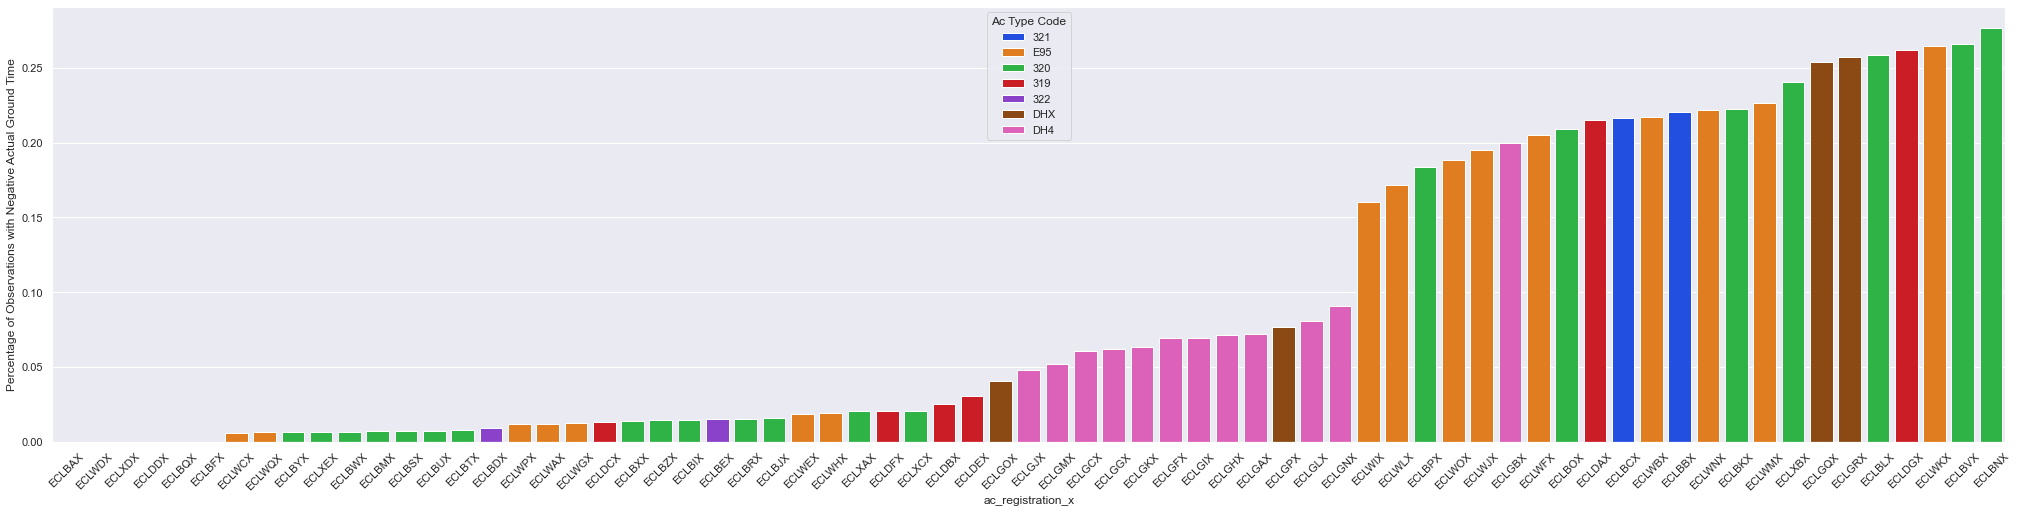

In [238]:
# A visualization of this:

# get data
temp = full_df[(full_df['rows_to_drop']==0) & (full_df['rows_to_drop_grounddelay']==0)]

# Percentage of negative Act Groundtime per registration 
temp = 1-temp[temp['Neg_Act_Groundtime']=='No'].groupby('ac_registration_x')['Neg_Act_Groundtime'].count()/temp.groupby('ac_registration_x')['Neg_Act_Groundtime'].count()

#Create dataframe that also includes the ac_type for coloring
temp = pd.DataFrame(temp).sort_values(by=['Neg_Act_Groundtime'])
temp = temp.merge(right = full_df[['Ac Type Code','ac_registration_x']],how = 'left', left_index = True, right_on = full_df['ac_registration_x']).drop_duplicates().dropna()

#Visualization
plt.xticks(rotation=45)
ax = sns.barplot(x = temp['ac_registration_x'], y = temp['Neg_Act_Groundtime'], hue=temp['Ac Type Code'], dodge = False, palette = 'bright')
ax.set(ylabel='Percentage of Observations with Negative Actual Ground Time')
plt.show()

Notes

Unfortunately, after quite some Analysis to why negative actual ground times appear, we cannot find any pattern hinting towards any data collection mistake. We see a pattern for certain Aircraft Registrations, but we cannot explain why it happens to them only. There seems to be only little correlation in between Ac Type Code and neg_act_groundtime. 

The only idea could be differing time zones and recording of off and onblocktimes in local time, skewing it, but there would also be no way to correct that as we do not have any time zone information. Also, this is unlikely to be the reason as negative ground times only selectively appear and not as a general happening on certain routes.

We therefore have to assume bad data and have to get rid of these observations. Negative actual ground times are no senseful information. By dropping those rows, we lose quite a bit of information, unfortunately. 

In [239]:
# Drop rows where Act Groundtime < 0
full_df["rows_to_drop"] = np.where(full_df['Act Groundtime']<1, 1, full_df["rows_to_drop"])
full_df[full_df["rows_to_drop"]>0].count()[0] # Number of rows we currently drop 

1217

## Rotational Analysis

During previous skimmings though data, we also realized that rotational mistakes happen from time to time and result in flight events which are looking weird. Let's have a look at them using a violin plot and displaying the data per rotation_mismatch

In [240]:
# count of remaining rotational mismatches
full_df[(full_df['rot_mismatch'] == True) & (full_df['rows_to_drop'] == 0) & (full_df['rows_to_drop_grounddelay'] == 0 )].count()[0]

#That's not many rotational mistakes remaining. 

45

In [241]:
# Investigating the rotational mistakes
remaining_rot_mismatches = full_df[(full_df['rot_mismatch'] == True) & (full_df['rows_to_drop'] == 0) & (full_df['rows_to_drop_grounddelay'] == 0 )]
remaining_rot_mismatches.shape

idx = remaining_rot_mismatches.index.values
idx

# Going through the rows
#i=1
#full_df.iloc[idx[i]-1 : idx[i]+2]

# Creating full data frame of rotational mistakes plus row above/below
N = 1
mask = (full_df[(full_df['rows_to_drop'] == 0) & (full_df['rows_to_drop_grounddelay'] == 0 )]['rot_mismatch']
        .rolling(2*N+1, center=True, min_periods=1)
        .max().astype(bool)
       )
df2 = full_df[(full_df['rows_to_drop'] == 0) & (full_df['rows_to_drop_grounddelay']== 0 )].loc[mask]

df2[0:10]

,leg_no,fn_number_x,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,fn_number_y,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,act_groundtime_new,sched_groundtime_new,mingt,rot_mismatch,flt_event_number,scheduled_block_time,actual_block_time,ground_delay,block_delay,rows_to_drop,rows_to_drop_grounddelay,last_flt,Neg_Act_Groundtime
676,271962550,EC2627,East Carmen,Susanmouth,2019-06-13,2019-06-13 15:30:00,2019-06-13,2019-06-13 17:05:00,2019-06-13 16:17:00,2019-06-13 17:45:00,ECLBEX,rotational problem,47.0,322,51,60,C,"['William Trevino_nan_nan_nan_ca', 'Lisa Austi...",['cp'],45.0,5.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,5.0,45.0,45.0,False,5,95.0,88.0,47.0,-7.0,0,0,0.0,No
678,271985389,EC2867,East Carmen,Kennethfort,2019-06-14,2019-06-14 05:05:00,2019-06-14,2019-06-14 07:15:00,2019-06-14 05:24:00,2019-06-14 07:33:00,ECLBEX,other problem,19.0,322,0,0,Start,"['Aaron Allen_nan_nan_nan_ca', 'Ian Odonnell_n...",[],215.0,229.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,229.0,215.0,45.0,True,1,130.0,129.0,19.0,-1.0,0,0,0.0,No
679,272012988,EC3187,East Carmen,Lloydtown,2019-06-14,2019-06-14 10:50:00,2019-06-14,2019-06-14 12:10:00,2019-06-14 11:22:00,2019-06-14 12:33:00,ECLBEX,other problem,32.0,322,81,85,C,"['Jennifer Jones_98_81_85_ca', 'Victoria Marti...",['ca'],45.0,38.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,38.0,45.0,45.0,False,2,80.0,71.0,32.0,-9.0,0,0,0.0,No
2521,271981275,EC2808,South Loriview,East Carmen,2019-06-12,2019-06-12 08:15:00,2019-06-12,2019-06-12 10:00:00,2019-06-12 08:40:00,2019-06-12 10:18:00,ECLBRX,other problem,25.0,320,57,80,A,"['Cindy Jackson DVM_62_57_80_cp', 'Charlotte J...",[],50.0,44.0,2019-06-12,EC2808,South Loriview,East Carmen,Kennethfort,2019-06-12 08:15:00,2019-06-12 10:00:00,2019-06-12 10:50:00,2019-06-12 12:50:00,50.0,271981275.0,272194166.0,23.0,NaN,12.0,44.0,50.0,40.0,False,2,105.0,98.0,25.0,-7.0,0,0,0.0,No
2524,271986377,EC2872,Kennethfort,East Carmen,2019-06-12,2019-06-12 13:35:00,2019-06-12,2019-06-12 15:35:00,2019-06-12 13:37:00,2019-06-12 15:16:00,ECLBRX,other problem,2.0,320,23,45,A,"['Paul Bryant_182_23_45_ca', 'Shannon Schmidt_...",[],460.0,479.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,479.0,460.0,40.0,True,5,120.0,99.0,2.0,-21.0,0,0,0.0,No
2526,271987838,EC2907,East Carmen,Desireeton,2019-06-13,2019-06-13 04:50:00,2019-06-13,2019-06-13 07:20:00,2019-06-13 05:11:00,2019-06-13 07:44:00,ECLBRX,other problem,21.0,320,0,0,Start,"['Angela Harris_nan_nan_nan_ca', 'Phillip Dunn...",[],45.0,22.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,22.0,45.0,40.0,False,1,150.0,153.0,21.0,3.0,0,0,0.0,No
3381,272200410,EC3025,East Carmen,Joneshaven,2019-06-10,2019-06-10 11:05:00,2019-06-10,2019-06-10 12:25:00,2019-06-10 11:27:00,2019-06-10 12:45:00,ECLBWX,other problem,22.0,320,0,0,Start,"['Jennifer Pham_nan_nan_nan_ca', 'David Lewis_...",[],45.0,42.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,42.0,45.0,40.0,False,3,80.0,78.0,22.0,-2.0,0,0,0.0,No
3382,271998872,EC3026,Joneshaven,East Carmen,2019-06-10,2019-06-10 13:10:00,2019-06-10,2019-06-10 14:30:00,2019-06-10 13:27:00,2019-06-10 14:33:00,ECLBWX,other problem,17.0,320,35,45,A,"['Joseph Roberts_180_35_45_ca', 'Joshua Carpen...",[],245.0,245.0,2019-06-10,EC3026,Joneshaven,East Carmen,East Dakota,2019-06-10 13:10:00,2019-06-10 14:30:00,2019-06-10 15:15:00,2019-06-10 17:45:00,45.0,271998872.0,272217600.0,17.0,NaN,NaN,245.0,245.0,40.0,True,4,80.0,66.0,17.0,-14.0,0,0,0.0,No
3384,271987836,EC2907,East Carmen,Desireeton,2019-06-11,2019-06-11 04:50:00,

(26676, 3)


c:\Users\Paul\.conda\envs\py310\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\Paul\.conda\envs\py310\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\Users\Paul\.conda\envs\py310\lib\site-packages\scipy\stats\stats.py:2857: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  pct = percentile_func(x, rng, axis=axis, interpolation=interpolation,
c:\Users\Paul\.conda\envs\py310\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if Loose

<AxesSubplot:xlabel='variable', ylabel='value'>

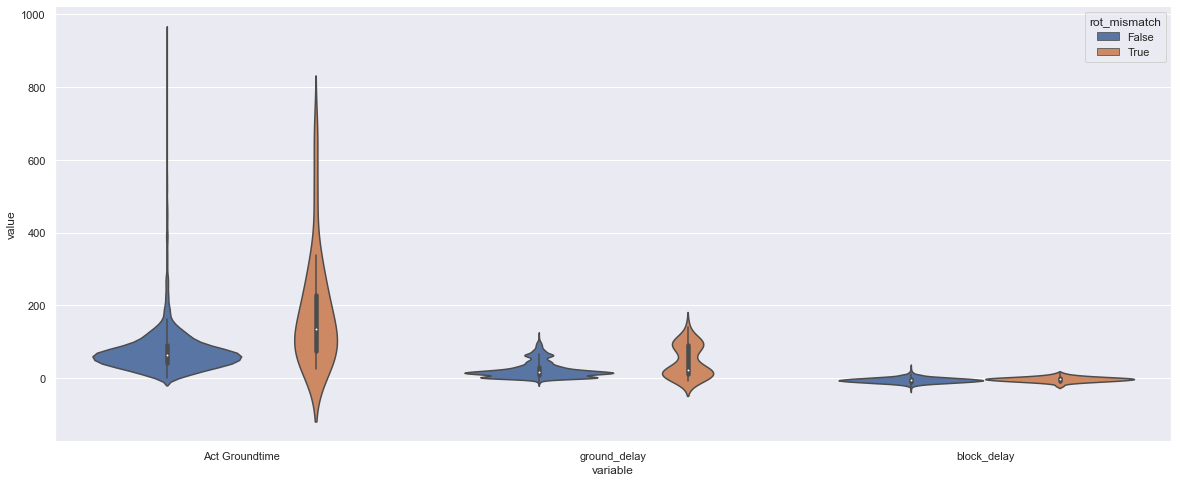

In [242]:
# Violin Plot delay dispersion ground and block per rot_mistake_indicator
sns.set(rc={'figure.figsize':(20, 8)})

# Get current dataset and drop rows that are dropped anyways
temp = full_df[(full_df['rows_to_drop']==0) & (full_df['rows_to_drop_grounddelay']==0)]
temp = pd.melt(temp, value_vars=['Act Groundtime','ground_delay', 'block_delay'], id_vars='rot_mismatch')
print(temp.shape)
sns.violinplot(x='variable', y='value', hue='rot_mismatch', data=temp)


In [243]:
# Violin Plot is misleading: We do not have negative values for Act Groundtime
temp[(temp['variable']=='Act Groundtime') & (temp['value']<1)]

,rot_mismatch,variable,value


Notes

Although the violinplot generally looks better than a boxplot, we see the downside here as well: The violinplot suggests that Act Groundtime still has negative values. However, this is definitely not the case, as we see in the cell above

c:\Users\Paul\.conda\envs\py310\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
c:\Users\Paul\.conda\envs\py310\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:xlabel='variable', ylabel='value'>

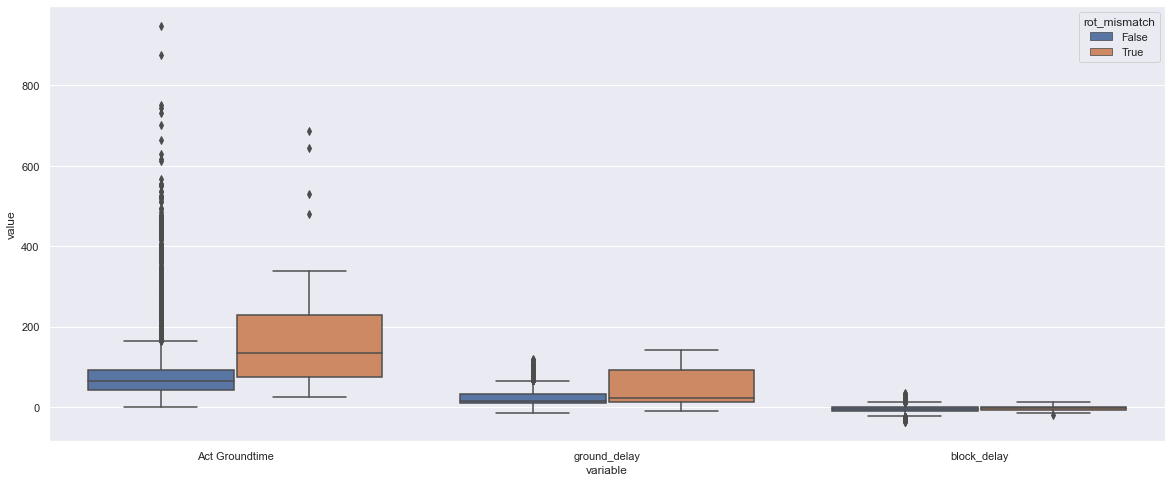

In [244]:
# The same, but as boxplot
sns.boxplot(x='variable', y='value', hue='rot_mismatch', data=temp)

Notes 

We see that the event of a rotational mismatch within the data changes the dispersion for Groundtime and ground_delay by quite a bit, while it does very little for block delay (which makes sense as rotational mistakes may falsify ground data, but not flight data). 

We drop rotational mistakes consequently. 

In [246]:
idx = full_df[full_df['rot_mismatch']==True].index
full_df.loc[idx,"rows_to_drop"] = 1

## Crew Variable Analysis

Let's revisit the variable definition for a moment:

- Crew Group: assignment of what happens to the whole crew after a flight
    - Start : First flight of day
    - A : all crew members stay on the aircraft for the next flight
    - B, B2: all crew members switch aircraft for the next flight
    - C: at least one crew member switches aircraft for the next flight
- TLC_trans: names of crew members on flight with some additional information attached to each name (but business does not know exactly which additional information is visible there)
- crew_type_change: rank (cp = pilot, ca = cabin member) of crew members, who changed aircraft

### Crew Group & TLC_trans

In [247]:
# Recalculate flt_event_number as it is wrong due to the dropped lines and goes up to 21
full_df["flt_event_number"] = full_df[(full_df['rows_to_drop']==0) & (full_df['rows_to_drop_grounddelay']==0)].groupby(['dep_sched_date', 'ac_registration_x']).cumcount()+1

In [248]:
# Crew Group reliabilty 

pd.crosstab(full_df['Crew Group'], full_df['flt_event_number'])

flt_event_number,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
Crew Group,,,,,,,,,,
A,87,1150,1234,812,656,312,171,11,5,3
B,20,91,54,72,32,21,1,1,0,0
B2,13,92,42,57,30,19,0,0,0,0
C,33,107,111,99,45,46,8,0,0,0
Start,1837,490,358,396,246,70,10,5,0,0


In [249]:
# TLC_trans reliability
# get duplicate values within TLC_trans
temp = full_df[(full_df['rows_to_drop']==0) & (full_df['rows_to_drop_grounddelay']==0)]['TLC_trans'].duplicated()
temp.value_counts()
# We have very few duplicates

False    8825
True       22
Name: TLC_trans, dtype: int64

Notes

- Crew Group is highly unreliable. 
    - A indicates that all crew members stay on the aircraft. A has the most cases. However, no line within TLC_trans is duplicated, i.e. would result in a category A. 
    - Furthermore, we have hundreds of cases, where "Start" is not the first flight. 
    - Start as a categorie doesn't even make sense as always the groundtime succeeding the flight is displayed - the category always has to be A, B, B2 or C
- TLC_trans is also unreliable
    - it is highly unlikely that such little number of flights have the same crew - just think of a return flight. Two flights with the same crew would result in a dupe value - but no dupes appear

Let's investigate whether we can take advantage of TLC_trans, extracting its content. Maybe we can get rid of some noise and maybe it helps reconstructing Crew Group

In [259]:
from ast import literal_eval

cabin_crew = []
cockpit_crew = []
trash_crew = []

for flight in full_df['TLC_trans']:
    cabin = []
    cockpit = []
    trash = []
    for crew_member_info in literal_eval(flight):
        if crew_member_info.split('_')[-1] == "cp":
            cockpit.append(crew_member_info.split('_')[0])
        elif crew_member_info.split('_')[-1] == "ca":
            cabin.append(crew_member_info.split('_')[0])
        else:
            print('the horror')
            trash.append(crew_member_info)
        #print(crew_member_info)

    # Sorting of lists
    cabin = sorted(cabin, key=str.lower)
    cockpit = sorted(cockpit, key=str.lower)
    trash = sorted(trash, key=str.lower)

    # Appending lists to column list
    cabin_crew.append(cabin)
    cockpit_crew.append(cockpit)
    trash_crew.append(trash)

full_df['cabin_crew'] = pd.Series(cabin_crew)
full_df['cockpit_crew'] = pd.Series(cockpit_crew)


def change_check(row):
    # If same registration and day
    if (row['ac_registration_x']==row['ac_registration_x-1']) & (row['dep_sched_date']==row['dep_sched_date-1']): 
        if (row['cockpit_crew']!=row['cockpit_crew-1']) & (row['cabin_crew']!=row['cabin_crew']):
            change = 'both'
        elif (row['cockpit_crew']!=row['cockpit_crew-1']) & (row['cabin_crew']==row['cabin_crew']):
            change = 'cockpit'
        elif (row['cockpit_crew']==row['cockpit_crew-1']) & (row['cabin_crew']!=row['cabin_crew']):
            change = 'cabin'
        else:
            change = 'no change'
    else:
        change = 'last flt of day'
    return change

full_df['ac_registration_x-1'] = full_df['ac_registration_x'].shift(-1)
full_df['dep_sched_date-1'] = full_df['dep_sched_date'].shift(-1)
full_df['cockpit_crew-1'] = full_df['cockpit_crew'].shift(-1)
full_df['cabin_crew-1'] = full_df['cabin_crew'].shift(-1)

full_df['Crewchange'] = full_df.apply(change_check, axis=1)

full_df = full_df.drop(['ac_registration_x-1','dep_sched_date-1','cockpit_crew-1','cabin_crew-1'], axis=1)


full_df.head()

,leg_no,fn_number_x,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,fn_number_y,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,act_groundtime_new,sched_groundtime_new,mingt,rot_mismatch,flt_event_number,scheduled_block_time,actual_block_time,ground_delay,block_delay,rows_to_drop,rows_to_drop_grounddelay,last_flt,Neg_Act_Groundtime,cabin_crew,cockpit_crew,Crewchange
0,272024970,EC3292,New Jessica,East Carmen,2019-06-01,2019-06-01 03:25:00,2019-06-01,2019-06-01 06:45:00,2019-06-01 03:50:00,2019-06-01 07:01:00,ECLBAX,other problem,25.0,321,0,0,Start,"['Sean Weeks_nan_nan_nan_ca', 'Tony Lloyd_nan_...",[],95.0,94.0,2019-06-01,EC3292,New Jessica,East Carmen,South Nathaniel,2019-06-01 03:25:00,2019-06-01 06:45:00,2019-06-01 08:20:00,2019-06-01 10:35:00,95.0,272024970.0,272022230.0,27.0,NaN,25.0,94.0,95.0,45.0,False,1.0,200.0,191.0,25.0,-9.0,0,0,0.0,No,"[Caleb Davidson, Cassandra Lewis, Sean Weeks, ...","[Andrew Patterson, Joshua Ellis]",cockpit
1,272022230,EC3257,East Carmen,South Nathaniel,2019-06-01,2019-06-01 08:20:00,2019-06-01,2019-06-01 10:35:00,2019-06-01 08:35:00,2019-06-01 10:41:00,ECLBAX,other problem,15.0,321,60,60,B,"['Toni Rodriguez_48_60_60_ca', 'Rachel Smith_4...",[],75.0,120.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,120.0,75.0,45.0,False,2.0,135.0,126.0,15.0,-9.0,0,0,0.0,No,"[Cathy Meyer, Charles Watson, Jessica Holmes, ...","[Mikayla Harris, Rachel Smith]",no change
2,272212848,EC3258,South Nathaniel,East Carmen,2019-06-01,2019-06-01 11:50:00,2019-06-01,2019-06-01 14:15:00,2019-06-01 12:41:00,2019-06-01 14:52:00,ECLBAX,rotational problem,51.0,321,68,75,A,"['Toni Rodriguez_127_68_75_ca', 'Rachel Smith_...",[],80.0,86.0,2019-06-01,EC3258,South Nathaniel,East Carmen,Joneshaven,2019-06-01 11:50:00,2019-06-01 14:15:00,2019-06-01 15:35:00,2019-06-01 17:00:00,80.0,272212848.0,271997824.0,25.0,NaN,NaN,86.0,80.0,45.0,False,3.0,145.0,131.0,51.0,-14.0,0,0,0.0,No,"[Cathy Meyer, Charles Watson, Jessica Holmes, ...","[Mikayla Harris, Rachel Smith]",cockpit
3,271997824,EC3021,East Carmen,Joneshaven,2019-06-01,2019-06-01 15:35:00,2019-06-01,2019-06-01 17:00:00,2019-06-01 16:18:00,2019-06-01 17:32:00,ECLBAX,rotational problem,43.0,321,64,70,B2,"['Tyler Morris_224_64_70_ca', 'Sergio Cummings...","['ca', 'cp', 'ca', 'ca', 'ca']",50.0,32.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,32.0,50.0,45.0,False,4.0,85.0,74.0,43.0,-11.0,0,0,0.0,No,"[Amanda Aguilar, Antonio Robbins, Jackie Black...","[Candace Brooks, Sergio Cummings]",no change
4,271998033,EC3022,Joneshaven,East Carmen,2019-06-01,2019-06-01 17:50:00,2019-06-01,2019-06-01 19:10:00,2019-06-01 18:04:00,2019-06-01 19:14:00,ECLBAX,other problem,14.0,321,42,50,A,"['Sergio Cummings_279_42_50_cp', 'Jackie Black...",[],NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,False,NaN,80.0,70.0,14.0,-10.0,0,1,NaN,No,"[Amanda Aguilar, Antonio Robbins, Jackie Black...","[Candace Brooks, Sergio Cummings]",last flt of day


Now we actually see some duplicates - TLC_trans might help us for the prediction! We will consequently create some crew change features out of it in the next step.

In [260]:
full_df = full_df.drop(['Crew Group','TLC_trans'], axis = 1)
full_df.head(3)

,leg_no,fn_number_x,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,fn_number_y,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,act_groundtime_new,sched_groundtime_new,mingt,rot_mismatch,flt_event_number,scheduled_block_time,actual_block_time,ground_delay,block_delay,rows_to_drop,rows_to_drop_grounddelay,last_flt,Neg_Act_Groundtime,cabin_crew,cockpit_crew,Crewchange
0,272024970,EC3292,New Jessica,East Carmen,2019-06-01,2019-06-01 03:25:00,2019-06-01,2019-06-01 06:45:00,2019-06-01 03:50:00,2019-06-01 07:01:00,ECLBAX,other problem,25.0,321,0,0,[],95.0,94.0,2019-06-01,EC3292,New Jessica,East Carmen,South Nathaniel,2019-06-01 03:25:00,2019-06-01 06:45:00,2019-06-01 08:20:00,2019-06-01 10:35:00,95.0,272024970.0,272022230.0,27.0,NaN,25.0,94.0,95.0,45.0,False,1.0,200.0,191.0,25.0,-9.0,0,0,0.0,No,"[Caleb Davidson, Cassandra Lewis, Sean Weeks, ...","[Andrew Patterson, Joshua Ellis]",cockpit
1,272022230,EC3257,East Carmen,South Nathaniel,2019-06-01,2019-06-01 08:20:00,2019-06-01,2019-06-01 10:35:00,2019-06-01 08:35:00,2019-06-01 10:41:00,ECLBAX,other problem,15.0,321,60,60,[],75.0,120.0,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,120.0,75.0,45.0,False,2.0,135.0,126.0,15.0,-9.0,0,0,0.0,No,"[Cathy Meyer, Charles Watson, Jessica Holmes, ...","[Mikayla Harris, Rachel Smith]",no change
2,272212848,EC3258,South Nathaniel,East Carmen,2019-06-01,2019-06-01 11:50:00,2019-06-01,2019-06-01 14:15:00,2019-06-01 12:41:00,2019-06-01 14:52:00,ECLBAX,rotational problem,51.0,321,68,75,[],80.0,86.0,2019-06-01,EC3258,South Nathaniel,East Carmen,Joneshaven,2019-06-01 11:50:00,2019-06-01 14:15:00,2019-06-01 15:35:00,2019-06-01 17:00:00,80.0,272212848.0,271997824.0,25.0,NaN,NaN,86.0,80.0,45.0,False,3.0,145.0,131.0,51.0,-14.0,0,0,0.0,No,"[Cathy Meyer, Charles Watson, Jessica Holmes, ...","[Mikayla Harris, Rachel Smith]",cockpit


### trans_time and sched_trans_time

In [ ]:
# trans time and sched trans time 

full_df.describe()

,leg_no,dep_delay,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,mingt,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,act_groundtime_new,sched_groundtime_new,flt_event_number,scheduled_block_time,actual_block_time,ground_delay,block_delay,rows_to_drop,rows_to_drop_grounddelay,last_flt
count,1.210100e+04,12101.000000,12101.000000,12101.000000,10088.000000,10026.000000,4229.000000,4229.000000,4.229000e+03,4.229000e+03,4229.000000,3.000000,3817.000000,10026.000000,10088.000000,8903.000000,12101.000000,12018.000000,12101.000000,12018.000000,12101.000000,12101.000000,10108.0
mean,2.720519e+08,25.805884,27.815305,35.086770,61.185071,64.850289,39.117995,56.066446,2.720601e+08,2.720432e+08,21.961693,21.505556,18.467645,64.850289,61.185071,2.991801,99.731840,94.963222,25.805884,21.185721,0.099661,0.166763,0.0
std,9.604818e+04,25.596928,31.861892,31.448448,58.664128,72.572299,3.250068,16.975623,9.904749e+04,9.309438e+04,4.324847,10.667400,11.913937,72.572299,58.664128,1.629127,42.767636,41.575881,25.596928,26.714576,0.299560,0.372780,0.0
min,2.719556e+08,-14.000000,-134.000000,0.000000,-280.000000,-383.000000,30.000000,-120.000000,2.719558e+08,2.719560e+08,15.000000,14.000000,0.000000,-383.000000,-280.000000,1.000000,30.000000,28.000000,-14.000000,-83.000000,0.000000,0.000000,0.0
25%,2.719829e+08,10.000000,0.000000,0.000000,45.000000,33.000000,40.000000,45.000000,2.719897e+08,2.719841e+08,18.000000,15.400000,13.000000,33.000000,45.000000,2.000000,75.000000,68.000000,10.000000,3.000000,0.000000,0.000000,0.0
50%,2.720117e+08,17.000000,28.000000,45.000000,50.000000,59.000000,40.000000,55.000000,2.720156e+08,2.720094e+08,22.000000,16.800000,17.000000,59.000000,50.000000,3.000000,95.000000,87.000000,17.000000,14.000000,0.000000,0.000000,0.0
75%,2.721016e+08,35.000000,49.000000,50.000000,65.000000,87.000000,40.000000,65.000000,2.721834e+08,2.720343e+08,26.000000,25.258333,22.000000,87.000000,65.000000,4.000000,115.000000,110.000000,35.000000,33.000000,0.000000,0.000000,0.0
max,2.723603e+08,476.000000,470.000000,495.000000,945.000000,947.000000,45.000000,100.000000,2.723601e+08,2.723580e+08,29.000000,33.716667,491.000000,947.000000,945.000000,10.000000,325.000000,333.000000,476.000000,467.000000,1.000000,1.000000,0.0


<AxesSubplot:xlabel='variable', ylabel='value'>

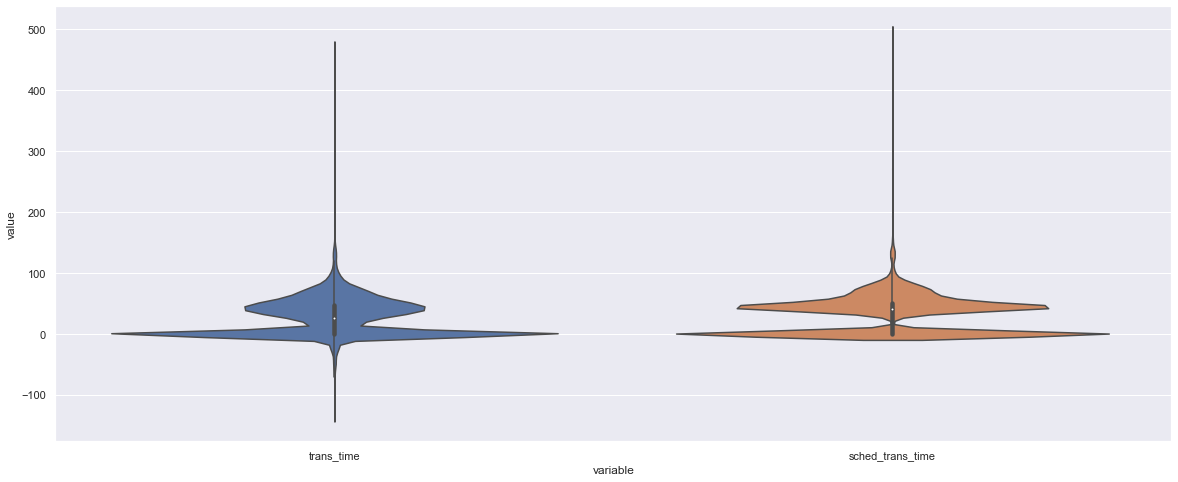

In [ ]:
temp = pd.melt(full_df[(full_df['rows_to_drop']==0) & (full_df['rows_to_drop_grounddelay']==0)][['trans_time', 'sched_trans_time']])

sns.violinplot(x='variable', y='value', data=temp)

Notes

trans time and sched trans time look ok data quality wise - although a bit skewed within its value dispersion. For the moment we keep the variable, but we might think about excluding it within our feature selection. We also note that those times are coming from TLC_trans.

### crew_type_change


In [261]:
# Crew Type Change 

print(len(full_df['crew_type_change'].value_counts()))
# We see that we have 56 categories of changes. That is a bit much, maybe it makes sense to look at that during feature engineering again. 

full_df['crew_type_change'].value_counts()[0:9]
# However, we also note that we barely have non-NAN values at all.
# As we have reconstructed this information above with our Crewchange variable, we drop crew_type_change.


56


[]                                10074
['cp']                              265
['ca']                              227
['cp', 'cp']                        198
['ca', 'cp', 'ca']                   74
['cp', 'ca', 'ca']                   73
['ca', 'ca', 'ca', 'cp', 'cp']       68
['cp', 'cp', 'ca', 'ca', 'ca']       65
['cp', 'ca', 'ca', 'ca', 'cp']       65
Name: crew_type_change, dtype: int64

In [262]:
full_df = full_df.drop('crew_type_change', axis = 1)